# Import Modules

In [38]:
import os, sys, math, random, ast, swifter, re, warnings, csv, json, pickle, matplotlib
import numpy as np
import pandas as pd
import datetime as dt
import portion as P
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint
from collections import namedtuple

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

# DataLoader

In [39]:
def data_loader(
    mode='sr',
    sel_dates=[],  exc_dates=[],
    sel_exps=[],   exc_exps=[],
    sel_routes=[], exc_routes=[], query_dates=False, show_all=False):
    # Specify root directory
    root_dir = '/Users/jackbedford/Desktop/MOXA/Code/data'
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
    
    if show_all:
        # Collect all experiment date_dirs
        date_dirs = [os.path.join(root_dir, s) for s in dates]
        
        for date, date_dir in zip(dates, date_dirs):
            # Specify path to your JSON file
            date = os.path.basename(date_dir)
            json_filepath = os.path.join(date_dir, f'{date}.json')
            # Read the JSON file and load its contents into a dictionary
            with open(json_filepath, 'r', encoding='utf-8') as json_file:
                my_dict = json.load(json_file)
            # If the JSON file is empty, then continue
            if not my_dict:
                continue
            # Show all the datasets in this database
            print(date, len(my_dict))
            for exp, item in my_dict.items():
                print({exp: item})
    
    if query_dates:     
        return dates

    # Collect Experiments
    date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
        # Specify the path to your JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        # Filter out useless datasets
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(sel_exps) != 0 and exp not in sel_exps:
                continue
            if len(exc_exps) != 0 and exp in exc_exps:
                continue
            if len(sel_routes) != 0 and item['route'] not in sel_routes:
                continue
            if len(exc_routes) != 0 and item['route'] in sel_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
                
    for date, exps in exps_dict.items():
        print(date, len(exps))
        for exp_name, exp in exps.items():
            print({exp_name: exp})
    
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv')
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                combos = list(it.combinations(devices, 2))
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        filepaths.append((
                            [os.path.join(data_dir1, 'handover_info_log.csv'), os.path.join(data_dir1, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir1, 'udp_uplk_loss_latency.csv')],
                            [os.path.join(data_dir2, 'handover_info_log.csv'), os.path.join(data_dir2, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir2, 'udp_uplk_loss_latency.csv')],
                            ))
    
    return filepaths

In [40]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['BR']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'skip': False, 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'ue': 'Phone', 'sync': None, 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園',

眾數: 0
中位數: 0.7507865
平均值: 3.9050327185792346
標準差: 10.932154377594989
最大值: 142.95689
最小值: 0.092357


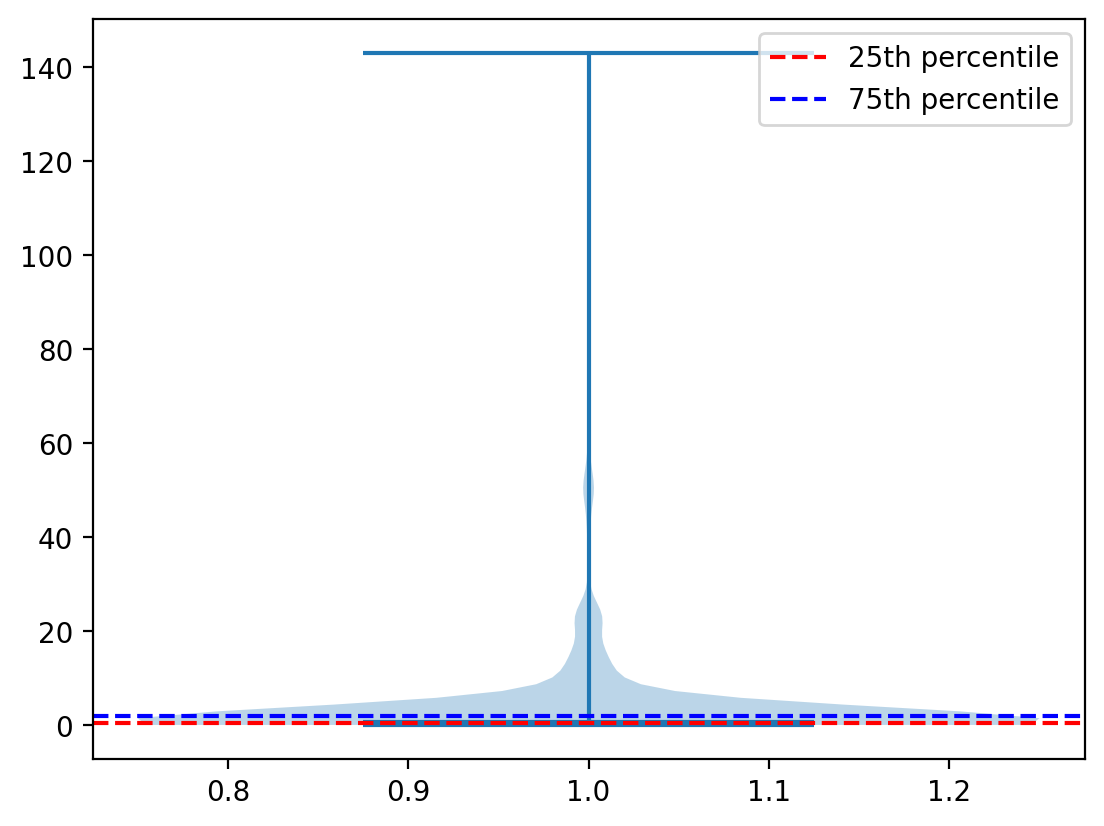

In [41]:
df = pd.read_csv(filepaths[0][0], parse_dates=['start', 'end'])[['type', 'start', 'end']]
df['next_start'] = df['start'].shift(-1)
df['period'] = (df['next_start'] - df['end']).dt.total_seconds()
data = df['period'].to_list()[:-1]

# 计算眾數
mode = np.bincount(data).argmax()
# 计算中位數
median = np.median(data)
# 计算平均值
mean = np.mean(data)
# 计算標準差
std_deviation = np.std(data)
# 计算最大值和最小值
maximum = np.max(data)
minimum = np.min(data)

# 输出结果
print("眾數:", mode)
print("中位數:", median)
print("平均值:", mean)
print("標準差:", std_deviation)
print("最大值:", maximum)
print("最小值:", minimum)

# Calculate the 25th and 75th percentiles
q25, q75 = np.percentile(data, [25, 75])
# Create the violin plot
plt.violinplot(data, showmeans=False, showmedians=True)
# Add lines for the 25th and 75th percentiles
plt.axhline(y=q25, color='r', linestyle='--', label='25th percentile')
plt.axhline(y=q75, color='b', linestyle='--', label='75th percentile')

# Add legend
plt.legend()
# Show the plot
plt.show()

# Basic Functions

In [42]:
# ----------------------------------------------------------------------------------------------
# set_data
# ----------------------------------------------------------------------------------------------

def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

# ----------------------------------------------------------------------------------------------
# parse_mi_ho
# ----------------------------------------------------------------------------------------------

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ----------------------------------------------------------------------------------------------
# mi_parse_handover
# ----------------------------------------------------------------------------------------------

def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

# ----------------------------------------------------------------------------------------------
# is_disjoint, interp
# ----------------------------------------------------------------------------------------------

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def interp(x, y, ratio):
    """
    Interpolation (線性內插法)

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

# Evaluation Auxiliary Functions

In [43]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(coef_table, x_list, type, center=0):
    _coef = list(coef_table.loc[type])
    
    if center != 0:
        x_list = [x - center for x in x_list]
        
    lower_bd = _coef[2]
    upper_bd = _coef[3]
    coef = _coef[5:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

def generate_random_boolean(probability_true):
    return random.random() < probability_true

# Profiling Functions

In [44]:
def setup_profile(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None, ts_col='Timestamp'):
    df_origin = df.copy()
    
    def setup_profile_instance(df, tag, start, intv, ts_col='Timestamp', w_size=0.01,
                           mode='dl', mets='lost'):
        
        # Relative window from timestamp
        df_plot = df[(df[ts_col] >= intv.lower) & (df[ts_col] < intv.upper)].copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
        
        # 四捨五入
        df_plot['cat_id'] = ((df_plot['rel_time'] + w_size / 2) // w_size) * w_size
        
        if mets == 'lost':
            # Calculate PLR
            ts_group = df_plot.groupby(['cat_id'])
            table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
            table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
            table['PLR'] = table['PLR'] * 100
        elif mets == 'excl':
            # Calculate ELR
            df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
            ts_group = df_plot.groupby(['cat_id'])
            table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
            table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
            table['ELR'] = table['ELR'] * 100
        
        return table, intv

    # Initialize
    A = {tag: {'tables': [], 'intrs': [], 'triggered': []} for tag in [*scope.keys(), 'stable']}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Centered at start timestamp of each handover event
        intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
        
        # Consider the stable duration before an event starts
        df_stable = df[df[ts_col] < intv.lower].copy()
        df_stable['Timestamp_sec'] = df_stable['Timestamp'].dt.floor('S')
        if not df_stable.empty:
            unique_timestamps = df_stable['Timestamp_sec'].unique()
            df_tmp = df_stable.copy()
            for ts in unique_timestamps:
                _start = ts + pd.Timedelta(seconds=0.5)
                _stable_intv = P.closed(ts, min(ts + pd.Timedelta(seconds=1), intv.lower))
                # Setup a stable profile instance
                table, _ = setup_profile_instance(df_tmp, tag='stable', start=_start, mode=mode, mets=mets, intv=_stable_intv)
                A['stable']['intrs'].append(1)
                if table['lost'].sum() > 0:
                    A['stable']['tables'].append(table)  # profile table instance
                    A['stable']['triggered'].append(1) # trigger loss
                # Update dataframe to accelerate
                df_tmp = df_tmp[df_tmp[ts_col] >= ts + pd.Timedelta(seconds=1)]
        
        # Setup a profile instance
        table, _ = setup_profile_instance(df, tag=tag, start=start, mode=mode, mets=mets, intv=intv)
        # print(tag)
        # print(table)
        
        # Update dataframe to accelerate the speed
        df = df[df[ts_col] >= intv.upper].copy()
        
        A[tag]['intrs'].append(intr)  # handover interruption time
        if table['lost'].sum() > 0:
            A[tag]['tables'].append(table)  # profile table instance
            A[tag]['triggered'].append(1) # trigger loss
        
        # Update stable interval
        stable_intv = stable_intv - intv
    
    # Consider the stable duration after the last event ends
    df_stable = df.copy()
    # df_stable = df[df[ts_col] >= intv.upper].copy()
    df_stable['Timestamp_sec'] = df_stable['Timestamp'].dt.floor('S')
    if not df_stable.empty:
        unique_timestamps = df_stable['Timestamp_sec'].unique()
        df_tmp = df_stable.copy()
        for ts in unique_timestamps:
            _start = ts + pd.Timedelta(seconds=0.5)
            _stable_intv = P.closed(ts, ts + pd.Timedelta(seconds=1))
            # Setup a stable profile instance
            table, _ = setup_profile_instance(df_tmp, tag='stable', start=_start, mode=mode, mets=mets, intv=_stable_intv)
            A['stable']['intrs'].append(1)
            if table['lost'].sum() > 0:
                A['stable']['tables'].append(table)  # profile table instance
                A['stable']['triggered'].append(1) # trigger loss
            # Update dataframe to accelerate
            df_tmp = df_tmp[df_tmp[ts_col] >= ts + pd.Timedelta(seconds=1)]

    # # Count lost and transferred packets under stable state
    # for intv in stable_intv:
    #     lower = intv.lower; upper = intv.upper
    #     df_tmp = df_origin[(df_origin[ts_col] > lower) & (df_origin[ts_col] <= upper)].copy().reset_index(drop=True)
        
    #     stable_pkt += len(df_tmp)
    #     if mets == 'lost':
    #         stable_miss += sum(df_tmp['lost'])
    #     elif mets == 'excl':
    #         stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    # stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # # Calculate stable duration, proportion
    # stable_duration = 0
    # stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    # for intv in stable_intv:
    #     stable_duration += (intv.upper - intv.lower).total_seconds()
        
    # total_duration = (df_origin.iloc[-1]['xmit_time'] - df_origin.iloc[0]['xmit_time']).total_seconds()
    # stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    # return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion
    return A, stable_miss, stable_pkt, stable_miss_rate, 0, 0, 0

In [45]:
def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

In [46]:
def build_all_profile(filepaths, scope, metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl'], sp_col='type'):

    D = {mm: {tag: {'tables': [], 'intrs': [], 'count': [], 'triggered': []} for tag in [*scope[mm].keys(), 'stable']} for mm in metrics}
    E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in metrics}

    N = len(filepaths)
    for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
        
        # if i > 0:     
        #     break
        
        print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
        df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
        df_dl = set_data(pd.read_csv(dl_filepath))
        df_ul = set_data(pd.read_csv(ul_filepath))
        
        for mm in metrics:
            mode = mm[:2]
            mets = mm[-4:]
            if mode == 'dl':
                df = df_dl.copy()
            else:
                df = df_ul.copy()
            
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion = \
                setup_profile(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in [*scope[f'{mode}_{mets}'].keys(), 'stable']:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['intrs']))
                D[f'{mode}_{mets}'][tag]['triggered'].append(len(A[tag]['triggered']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
                
    return D, E, scope

In [47]:
def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        thr = round(total * 0.9973)
        # thr = round(total * 0.9876)
        # thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

# Setup Profiles

In [48]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['BR']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

# sampled_filepaths = filepaths[-9:]
filepaths = filepaths[:-9]

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'skip': False, 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'ue': 'Phone', 'sync': None, 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園',

## Stage 1: fix 5, 10 seconds

In [49]:
lookup = {
        'LTEH': 'HO',
        'ENBH': 'HO',
        'MCGH': 'HO',
        'MNBH': 'HO',
        'SCGA': 'HO',
        'SCGM': 'HO',
        'SCGR-I': 'HO',
        'SCGR-II': 'HO',
        'SCGC-I': 'HO',
        'SCGC-II': 'HO',
        'MCGF': 'RLF',
        'NASR': 'RLF',
        'SCGF': 'RLF',
    }
# metrics=['dl_lost']
# Category_scope = {
#     mets: {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)} for mets in metrics
# }
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in metrics }

# # df_ho = pd.read_csv(filepaths[0][0], parse_dates=['start', 'end'])
# # df = set_data(pd.read_csv(filepaths[0][1]))

# # A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion = \
# #     setup_profile(df=df, df_ho=df_ho, scope=scope[f'dl_lost'], sp_col='type')

# HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
# print('****************************************************************')


# ****************************************************************
metrics=['dl_lost']

Category_scope = {
    mets: {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)} for mets in metrics
}

# columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
# sp_col = 'type'

scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in metrics }

# pprint(scope, sort_dicts=False)

HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
print('****************************************************************')

0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
1/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
1/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
1/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)
2/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP

LTEH
Number of Event: 1271
Number of Triggered: 72
Average Duration: 0.018905019669551534 seconds
[(-4.4, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.4, 5.0) 7.5


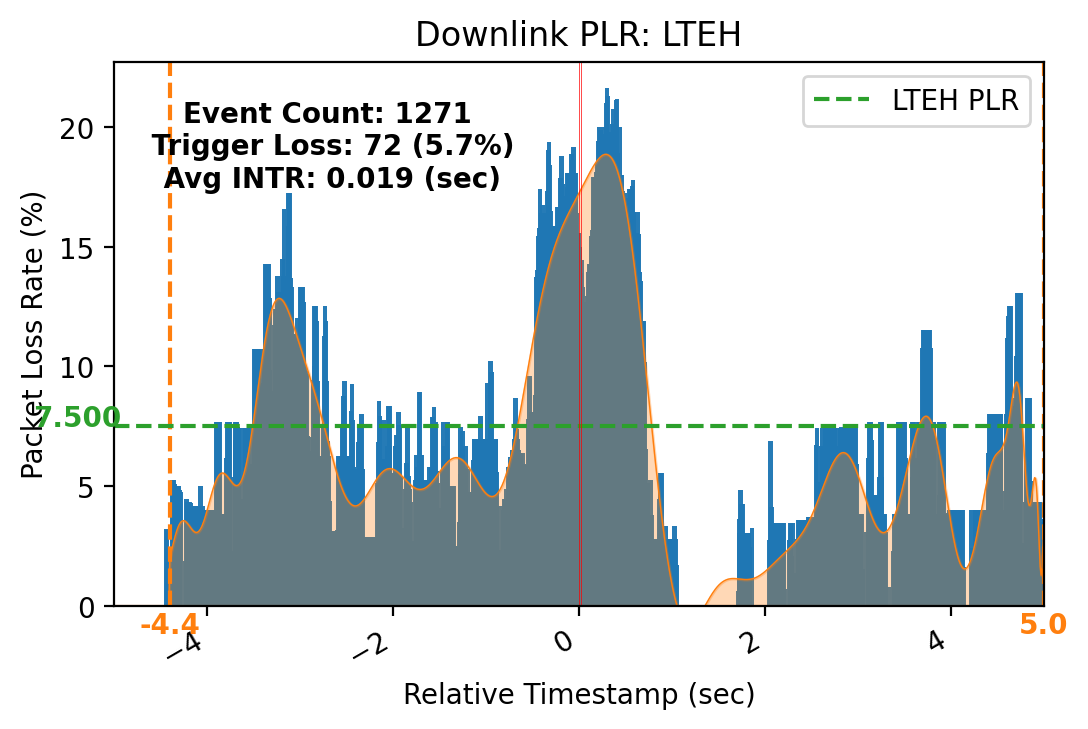

ENBH
Number of Event: 4101
Number of Triggered: 153
Average Duration: 0.019300927822482324 seconds
[(-5.0, 3.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.0, 3.5) 5.88


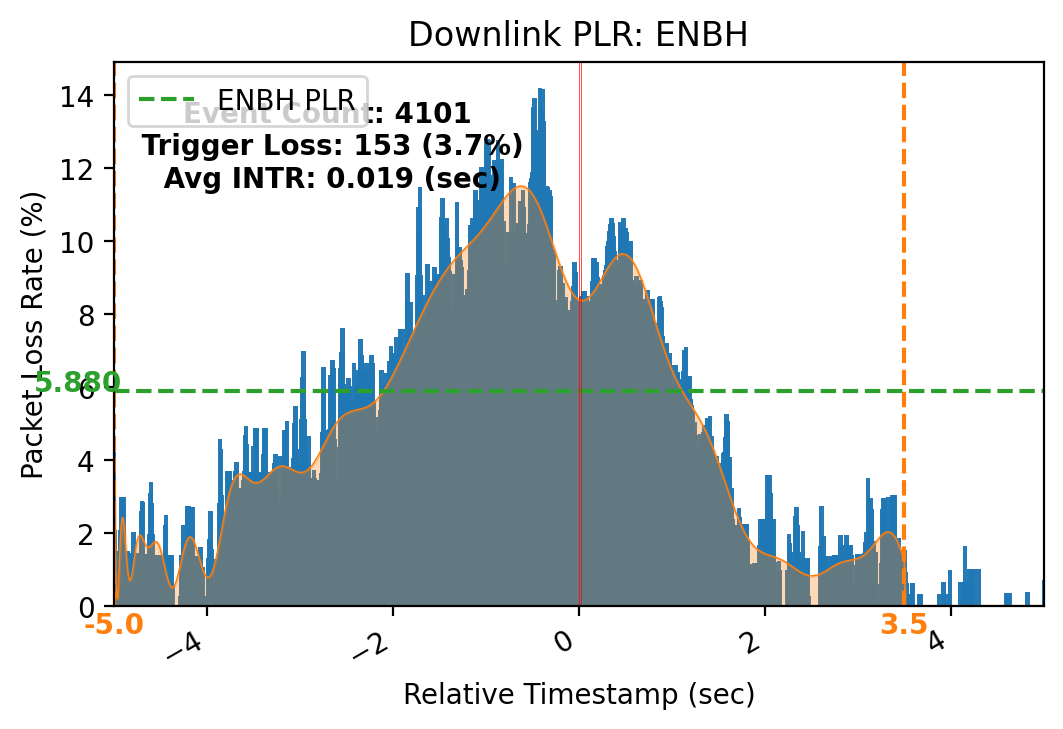

MCGH
Number of Event: 482
Number of Triggered: 72
Average Duration: 0.01852598755186722 seconds
[(-1.3, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.3, 5.0) 7.593


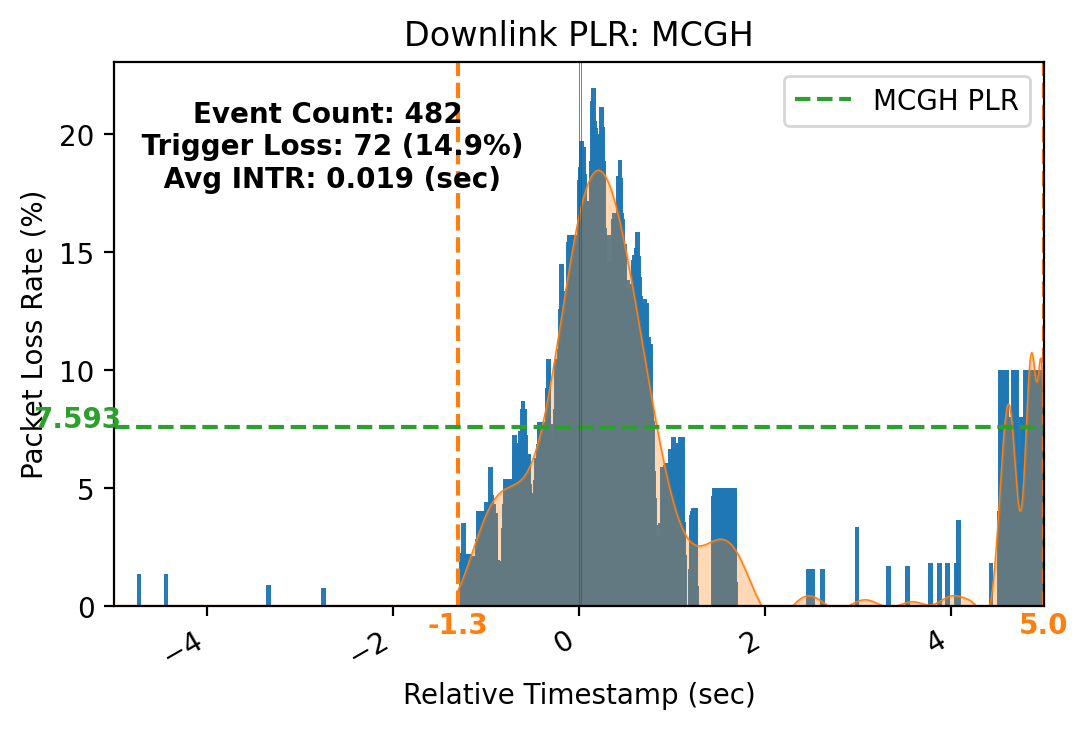

MNBH
Number of Event: 1494
Number of Triggered: 299
Average Duration: 0.02105363386880857 seconds
[(-4.7, 4.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.7, 4.0) 6.782


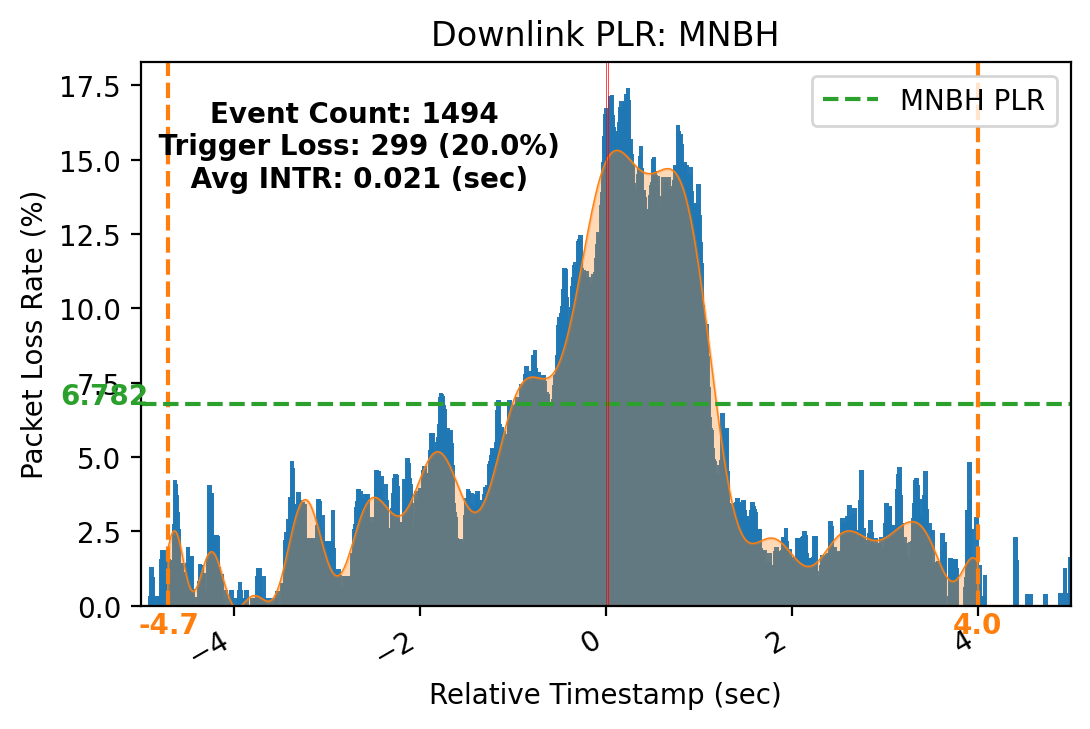

SCGA
Number of Event: 300
Number of Triggered: 23
Average Duration: 0.015681603333333335 seconds
[(-0.3, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.3, 5.0) 5.051


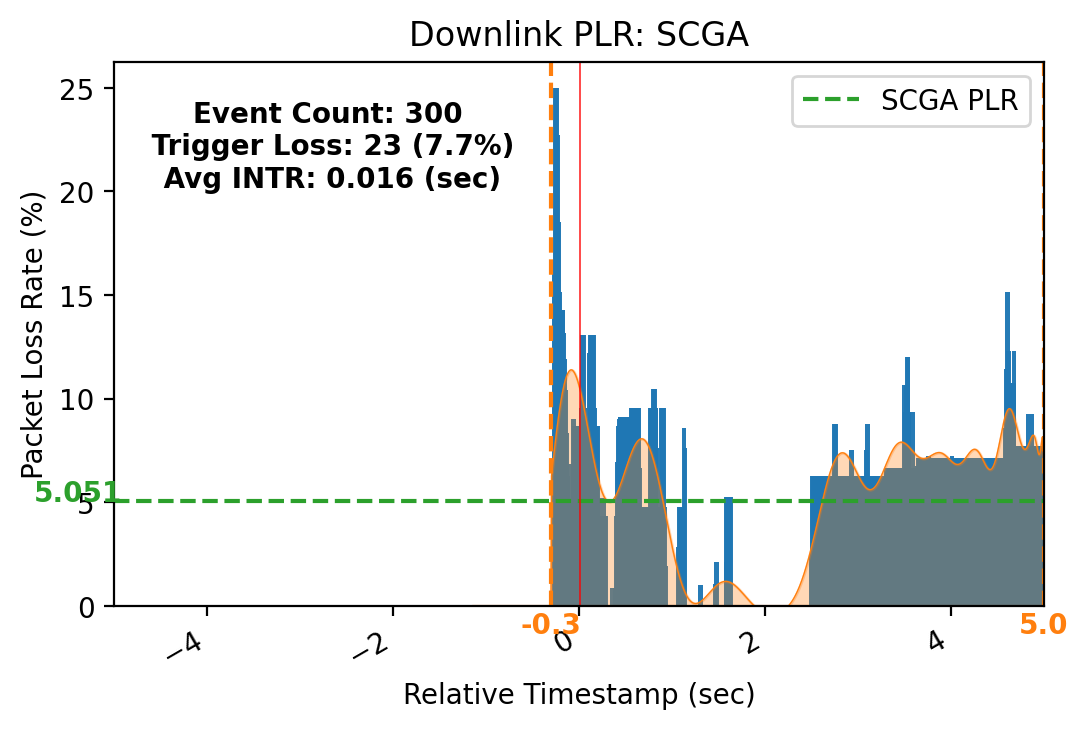

SCGM
Number of Event: 1696
Number of Triggered: 322
Average Duration: 0.0170713125 seconds
[(-4.7, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.7, 5.0) 2.753


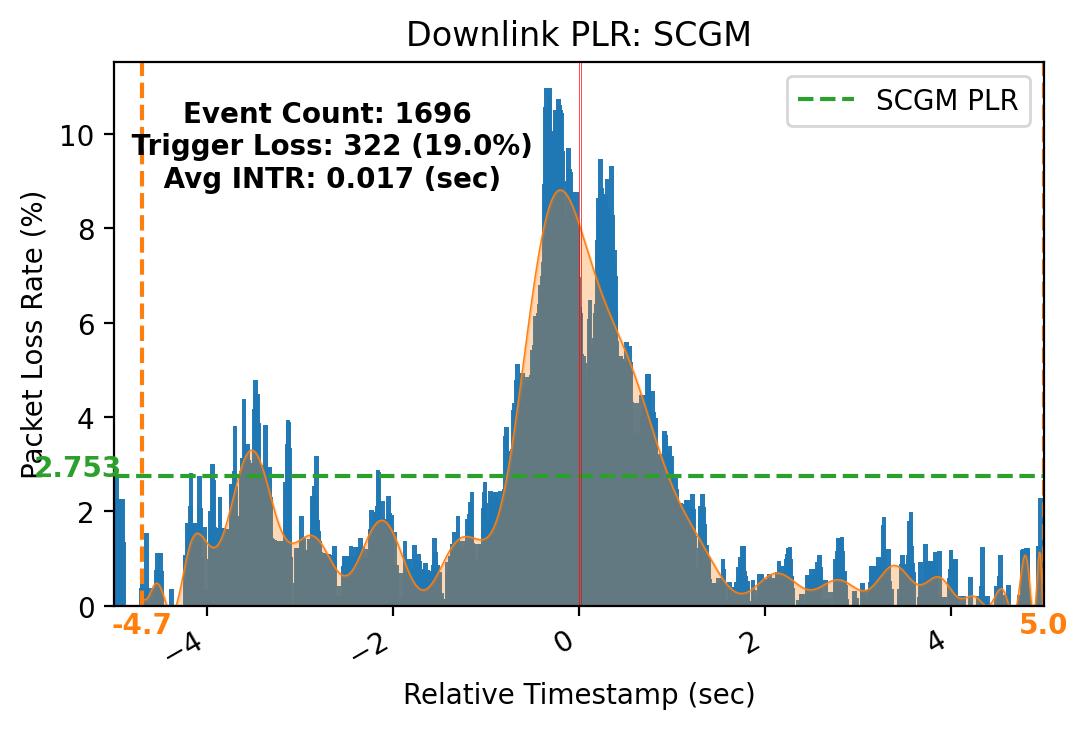

SCGR-I
Number of Event: 2
Number of Triggered: 1
Average Duration: 0.036322999999999994 seconds
[(-0.1, 1.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 1.2) 2.344


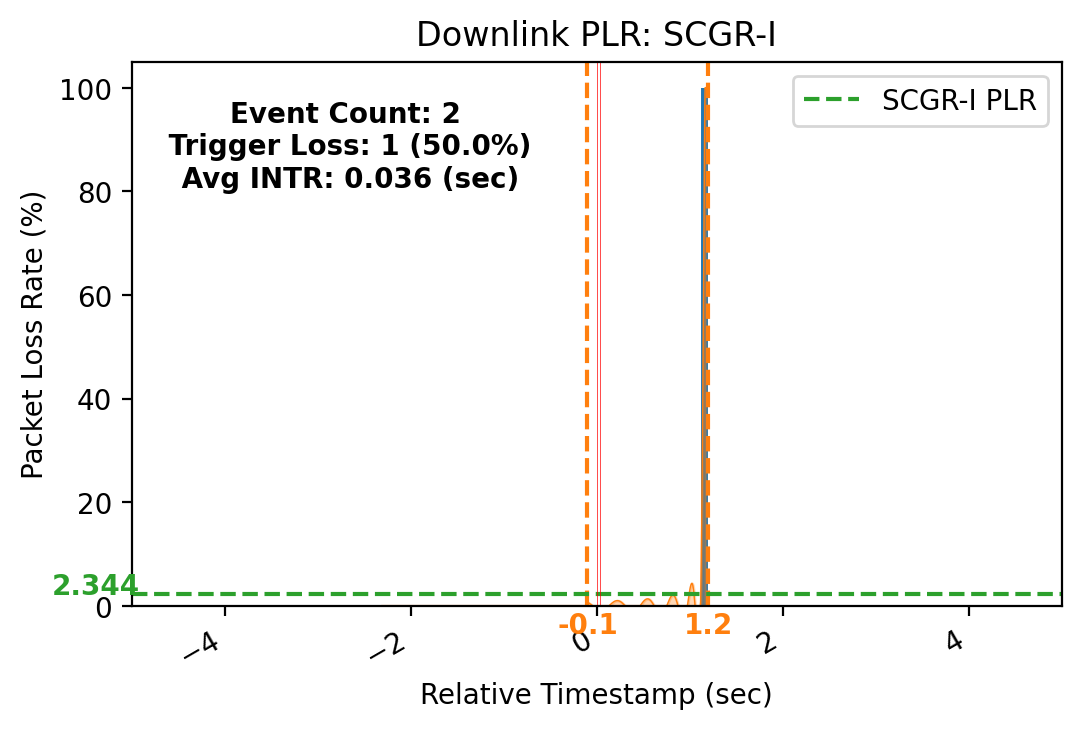

SCGR-II
Number of Event: 265
Number of Triggered: 16
Average Duration: 0.033766181132075475 seconds
[(-2.5, 1.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-2.5, 1.5) 17.623


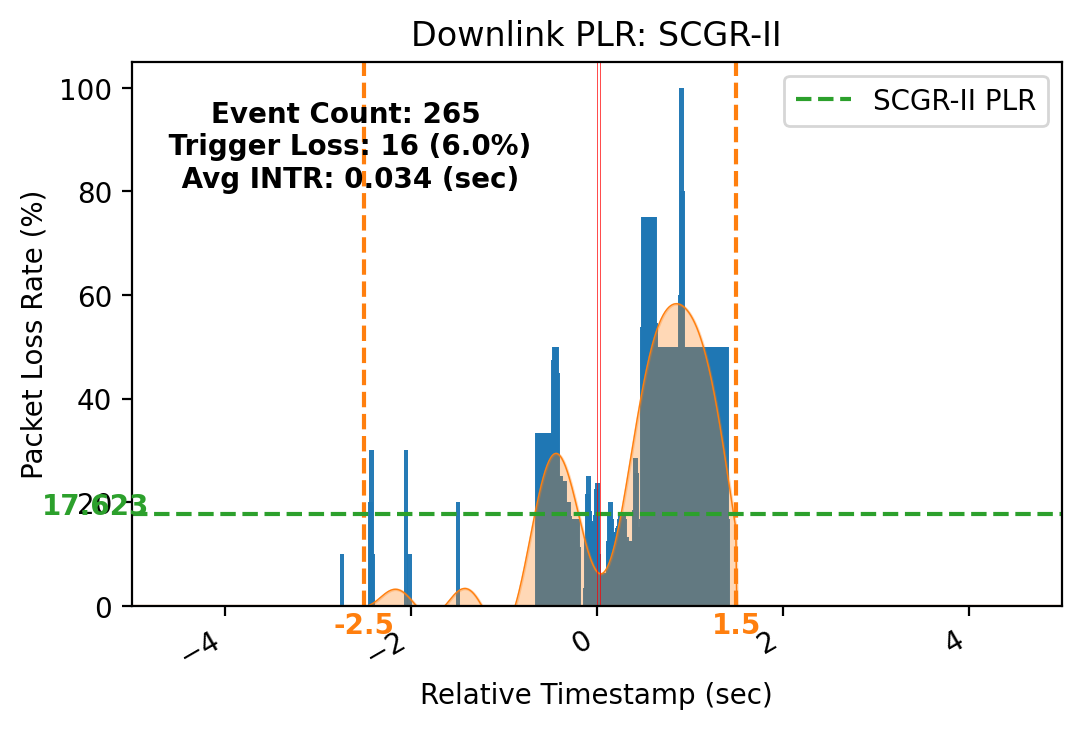

SCGC-I
Number of Event: 12
Number of Triggered: 10
Average Duration: 0.5283221666666666 seconds
[(-4.6, 2.7)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.6, 2.7) 3.144


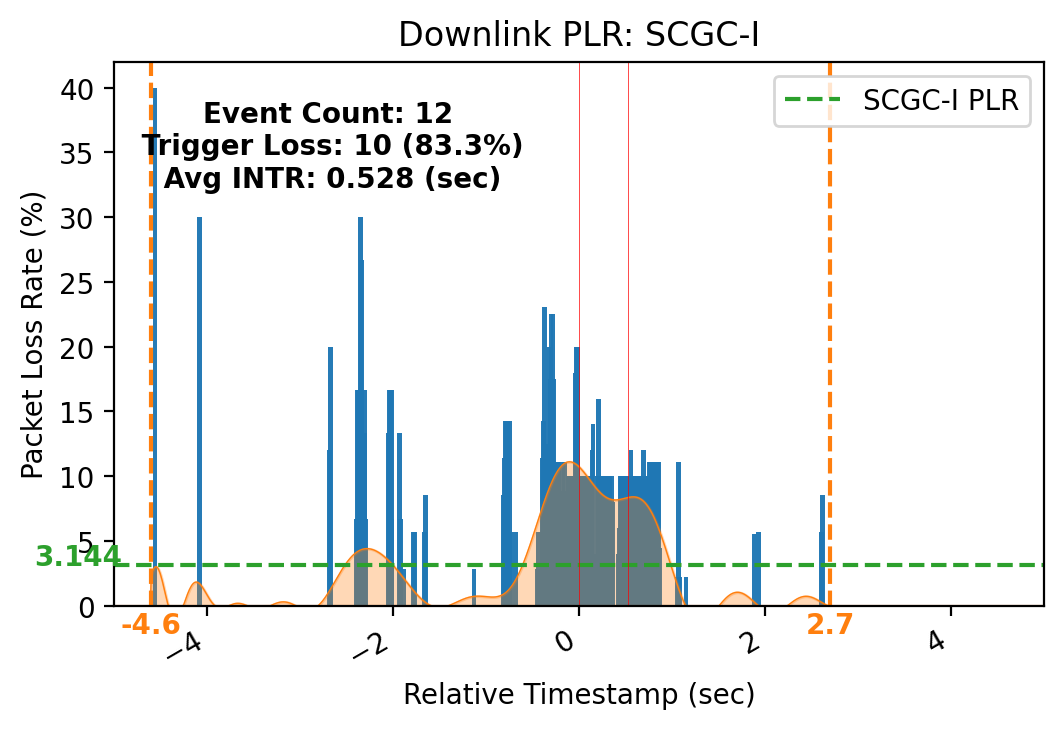

SCGC-II
Number of Event: 58
Number of Triggered: 14
Average Duration: 0.38874396551724144 seconds
[(-1.1, 4.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.1, 4.8) 8.873


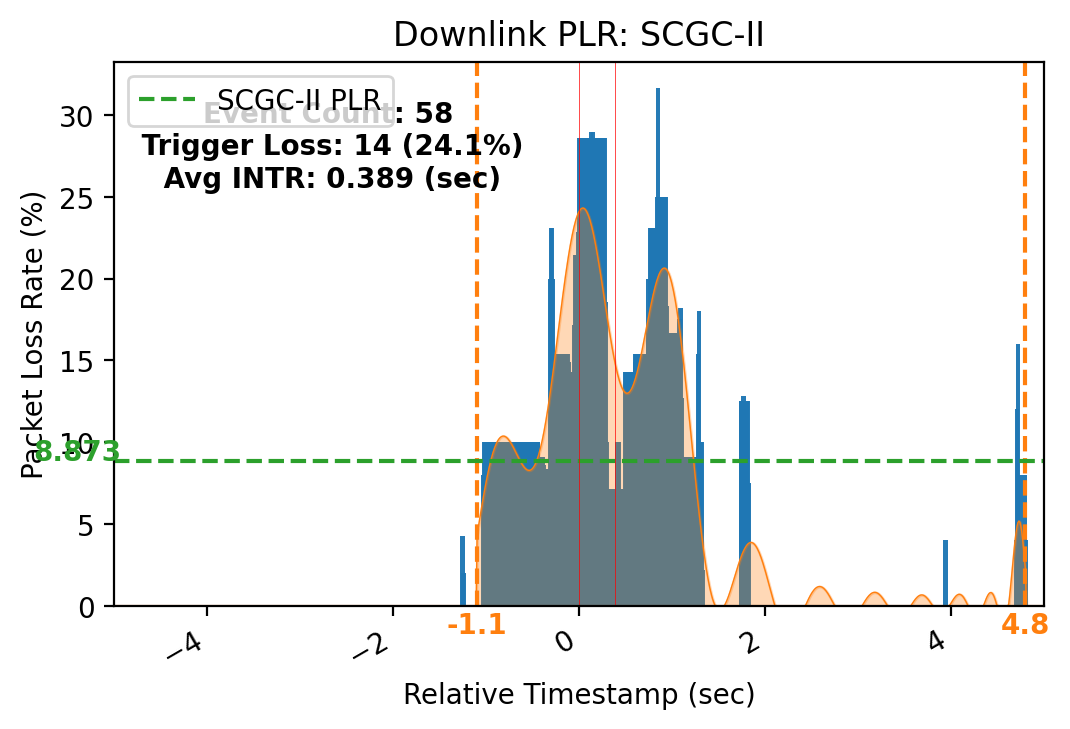

MCGF
Number of Event: 390
Number of Triggered: 342
Average Duration: 0.07972542307692308 seconds
[(-5.5, 1.7), (-5.4, 1.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.5, 1.7) 30.792


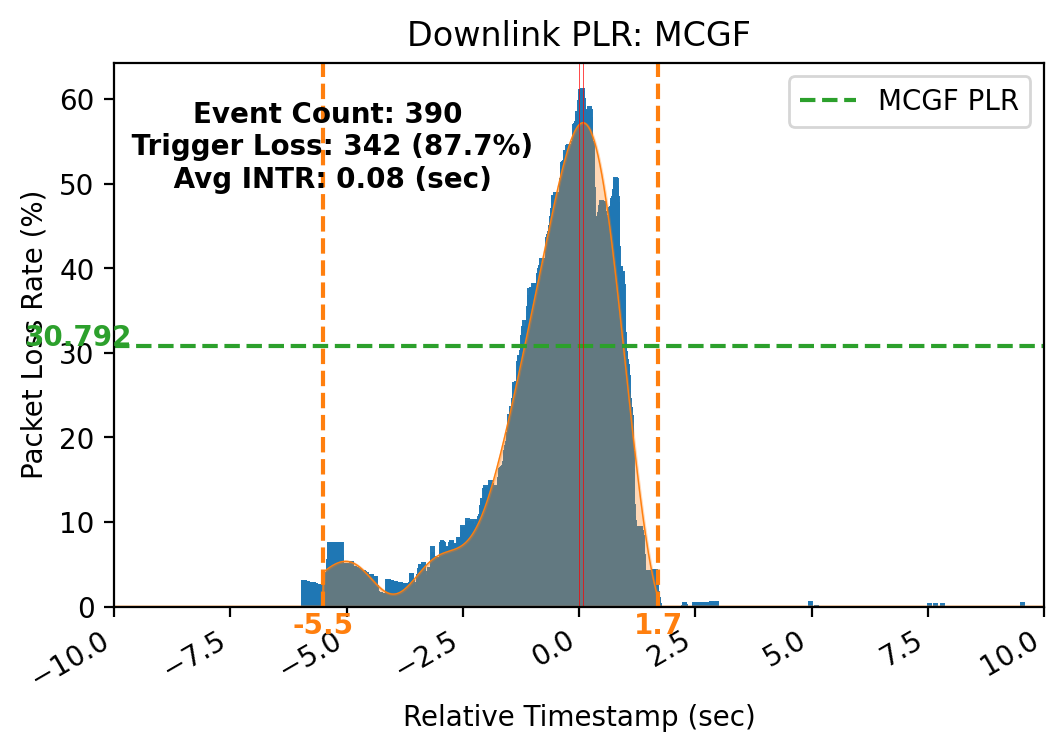

NASR
Number of Event: 11
Number of Triggered: 11
Average Duration: 0.44186245454545453 seconds
[(-4.0, 1.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.0, 1.5) 59.453


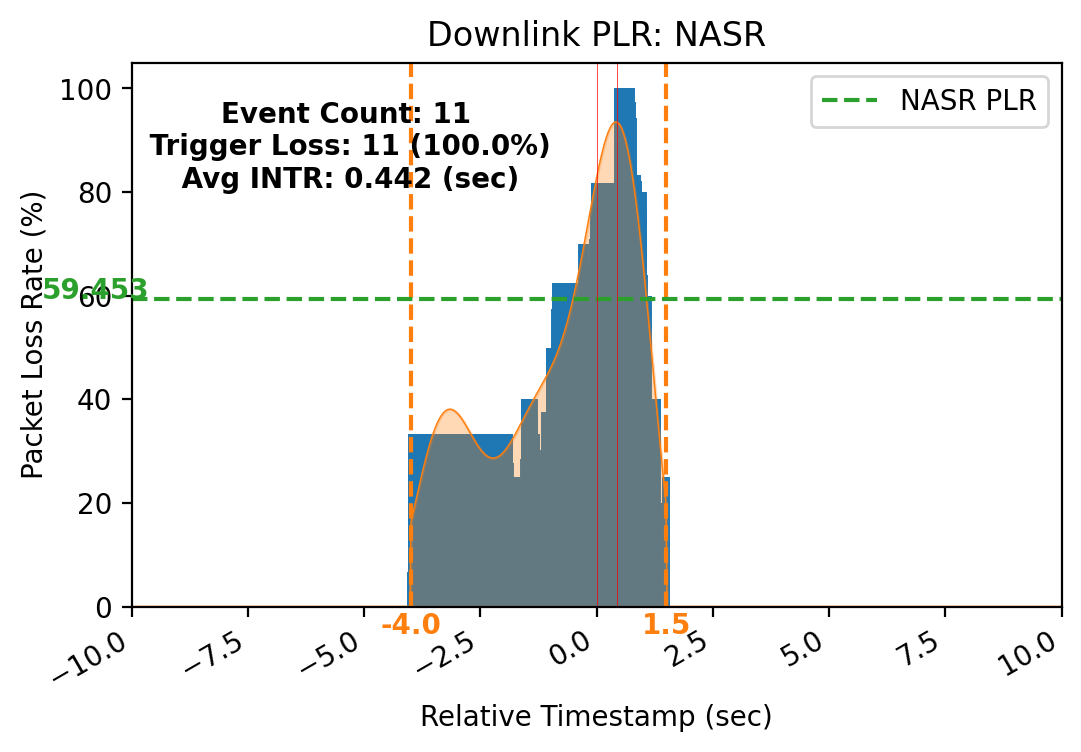

SCGF
Number of Event: 742
Number of Triggered: 25
Average Duration: 0.12380869002695419 seconds
[(-3.9, 2.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-3.9, 2.5) 9.427


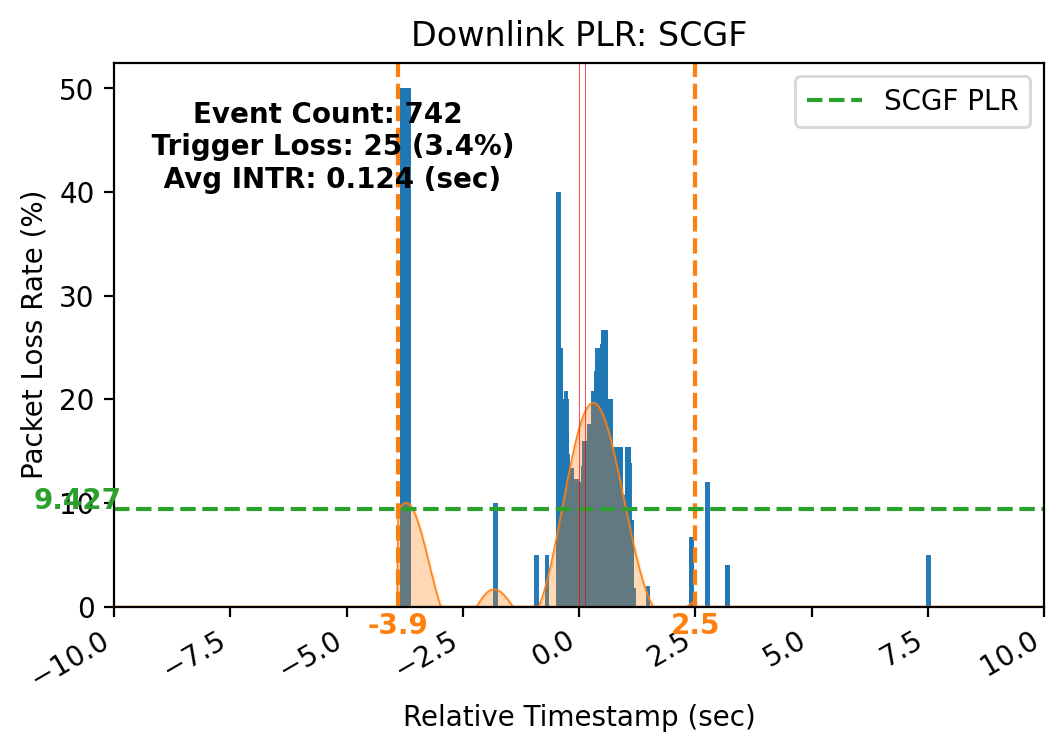

stable
Number of Event: 58869
Number of Triggered: 367
Average Duration: 1.0 seconds
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.5) 22.689


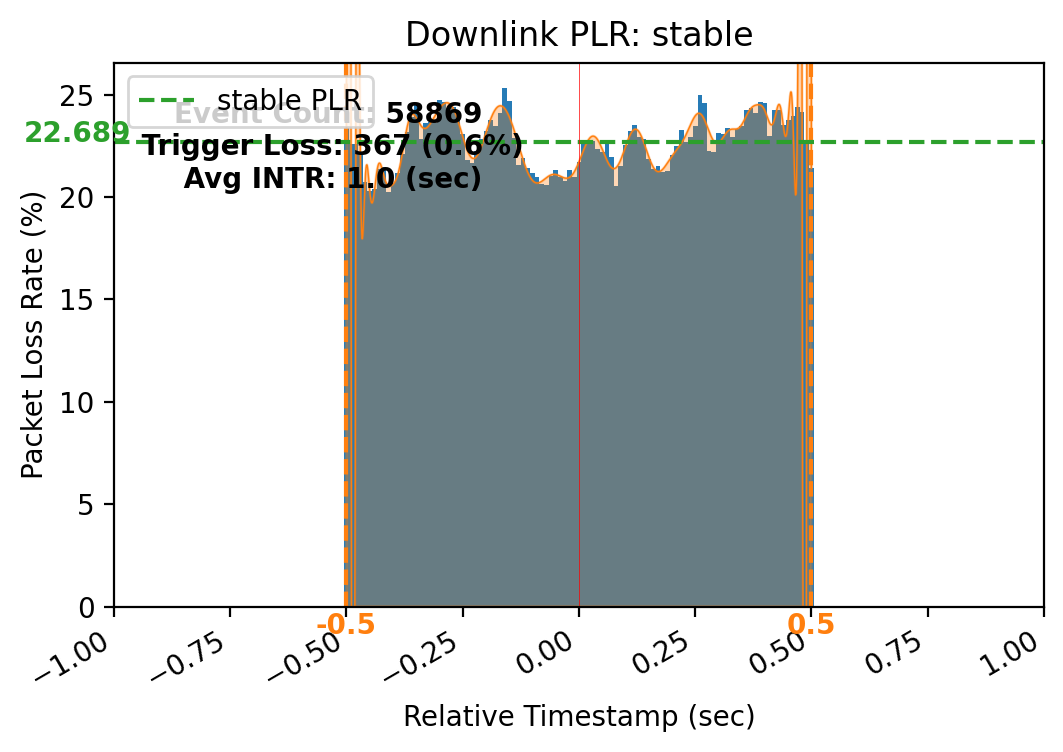

{'dl_lost': {'LTEH': (-4.4, 5.0),
             'ENBH': (-5.0, 3.5),
             'MCGH': (-1.3, 5.0),
             'MNBH': (-4.7, 4.0),
             'SCGA': (-0.3, 5.0),
             'SCGM': (-4.7, 5.0),
             'SCGR-I': (-0.1, 1.2),
             'SCGR-II': (-2.5, 1.5),
             'SCGC-I': (-4.6, 2.7),
             'SCGC-II': (-1.1, 4.8),
             'MCGF': (-5.5, 1.7),
             'NASR': (-4.0, 1.5),
             'SCGF': (-3.9, 2.5),
             'stable': (-0.5, 0.5)}}


In [50]:
# # de-comment while not running the first time
# D = HOType_D.copy()
# E = HOType_E.copy()
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# # *******************************************************************************************
D = HOType_D.copy()
E = HOType_E.copy()
scope = Initial_scope.copy()
# metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']
metrics=['dl_lost']

coef_tpl = pd.DataFrame(columns=['count', 'triggered', 'PLR/ELR', 'lower_bd', 'upper_bd', 'intr', *list(range(71))])
for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']:
    coef_tpl.loc[tag] = [0, 0, 0, -5, 5, 0, *np.zeros(71)]
for tag in ['MCGF', 'NASR', 'SCGF']:
    coef_tpl.loc[tag] = [0, 0, 0, -10, 10, 0, *np.zeros(71)]
coef_tpl.loc['stable'] = ['-', '-', 0, '-', '-', '-', *np.zeros(71)]
    
coef_df = {mets: coef_tpl.copy() for mets in metrics}

# coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

dist_df = {mets: {tag: pd.DataFrame(columns=['cat_id', 'tx_count', 'lost', 'PLR']) for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF', 'stable']} for mets in metrics}

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in metrics }

for tag in [*scope[list(scope.keys())[0]].keys(), 'stable']:
    if len(D[list(D.keys())[0]][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
    
    for mm in metrics:
        mode = mm[:2]
        mets = mm[-4:]
        
        if mets == 'lost':
            stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_PLR
        elif mets == 'excl':
            stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_ELR
            
        table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
        
        print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
        print('Number of Triggered:', sum(D[f'{mode}_{mets}'][tag]['triggered']))
        print('Average Duration:', intr, 'seconds')
        
        if tag == 'stable':
            min_scope = (-0.5, 0.5)
        else:
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
        
        if min_scope != 0:
            new_scope[f'{mode}_{mets}'][tag] = min_scope
        
        # def plot_polynomial(scope, mode, mets, ):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # # *********************************************************
        # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
        # new_scope[f'{mode}_{mets}'][tag] = min_scope
        # # *********************************************************
        
        if tag == 'stable':
            left = -0.5; right = 0.5
        else:
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
        bound = math.ceil(max(abs(right), abs(left)))
        left = -bound; right = bound
        ax.set_xlim(left, right)
        
        # width = 0.015 * (right - left)
        width = 0.005 * (right - left)
        if mets == 'lost':
            ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
        elif mets == 'excl':
            ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
            
        ax.set_ylim(0, max(1, ax.get_ylim()[1]))
        bottom, top = ax.get_ylim()

        if min_scope != 0:
            ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
            ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
            ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            
            bleft = min_scope[0]
            bright = min_scope[1]
            
            x = np.asarray(table['cat_id'], dtype=np.float64)
            if mets == 'lost':
                y = np.asarray(table['PLR'], dtype=np.float64)
            elif mets == 'excl':
                y = np.asarray(table['ELR'], dtype=np.float64)
                
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                z = np.polyfit(x, y, 70)
                p = np.poly1d(z)
            xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
            
            coef = p.coefficients
            
            ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
            ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
        
        if mets == 'lost':
            # ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
            # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable PLR:', stable_PLR)
                    print('Downlink PLR', min_scope, PLR)
                elif mode == 'ul':
                    print('Uplink Stable PLR:', stable_PLR)
                    print('Uplink PLR', min_scope, PLR)
                ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        elif mets == 'excl':
            # ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
            # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable ELR:', stable_ELR)
                    print('Downlink ELR', min_scope, ELR)
                elif mode == 'ul':
                    print('Uplink Stable ELR:', stable_ELR)
                    print('Uplink ELR', min_scope, ELR)
                ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                
        count = sum(D[f'{mode}_{mets}'][tag]['count'])
        triggered = sum(D[f'{mode}_{mets}'][tag]['triggered'])
        trigger_rate = sum(D[f'{mode}_{mets}'][tag]['triggered']) / (sum(D[f'{mode}_{mets}'][tag]['count']) + 1e-9) * 100
        intr = round(intr, 3)
        ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Trigger Loss: {triggered} ({round(trigger_rate, 1)}%)\n Avg INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
        
        # ******************************************************************************************************************
        if min_scope != 0:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, PLR, bleft, bright, intr, *list(coef)]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, ELR, bleft, bright, intr, *list(coef)]
            # display(table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)])
            dist_df[f'{mode}_{mets}'][tag] = table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)].reset_index(drop=True).copy()
        else:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            # display(table)
            dist_df[f'{mode}_{mets}'][tag] = table.copy()
        # ******************************************************************************************************************
        
        if mode == 'dl':
            if mets == 'lost':
                ax.set_title(f'Downlink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Downlink ELR: {tag}')
        elif mode == 'ul':
            if mets == 'lost':
                ax.set_title(f'Uplink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Uplink ELR: {tag}')
        
        if mets == 'lost':
            ax.set_ylabel('Packet Loss Rate (%)')
        elif mets == 'excl':
            ax.set_ylabel('Excessive Latency Rate (%)')
        ax.set_xlabel('Relative Timestamp (sec)')
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
# HOType_scope = new_scope.copy()

## Stage 2: Customize scope

In [51]:
coef_dl_lost = coef_df['dl_lost'].copy()
dist_dl_lost = dist_df['dl_lost'].copy()

scope = {'dl_lost': {}}
for tag, lower_bd, upper_bd in zip(coef_dl_lost.index[:-1], coef_dl_lost['lower_bd'].to_numpy()[:-1], coef_dl_lost['upper_bd'].to_numpy()[:-1]):
    # print(tag, lower_bd, upper_bd)
    scope['dl_lost'][tag] = (lower_bd, upper_bd)
    
pprint(scope)

HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
print('****************************************************************')

pprint(Initial_scope)

{'dl_lost': {'ENBH': (-5.0, 3.5),
             'LTEH': (-4.4, 5.0),
             'MCGF': (-5.5, 1.7),
             'MCGH': (-1.3, 5.0),
             'MNBH': (-4.7, 4.0),
             'NASR': (-4.0, 1.5),
             'SCGA': (-0.3, 5.0),
             'SCGC-I': (-4.6, 2.7),
             'SCGC-II': (-1.1, 4.8),
             'SCGF': (-3.9, 2.5),
             'SCGM': (-4.7, 5.0),
             'SCGR-I': (-0.1, 1.2),
             'SCGR-II': (-2.5, 1.5)}}
0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
0/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
1/45 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
1/45 /Users/jackbedford/Desktop/MOXA/Code/d

LTEH
Number of Event: 1271
Number of Triggered: 70
Average Duration: 0.018905019669551534 seconds
[(-4.4, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.4, 5.0) 7.959


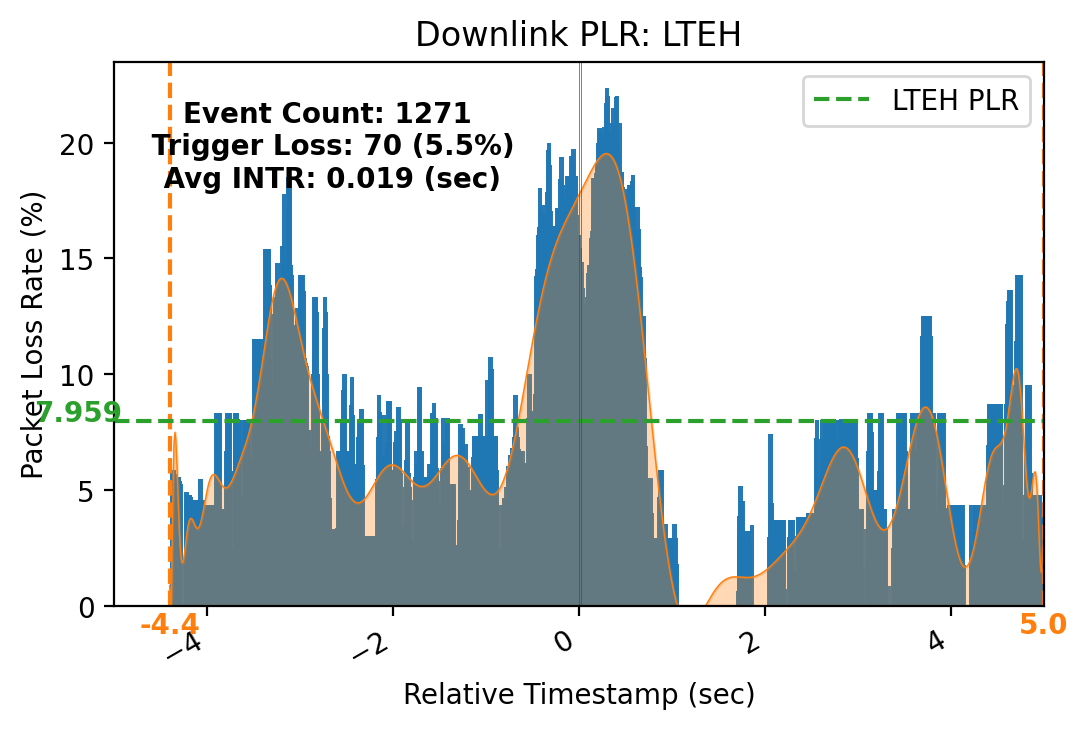

ENBH
Number of Event: 4030
Number of Triggered: 143
Average Duration: 0.01927430992555831 seconds
[(-5.0, 3.4), (-4.9, 3.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.0, 3.4) 6.357


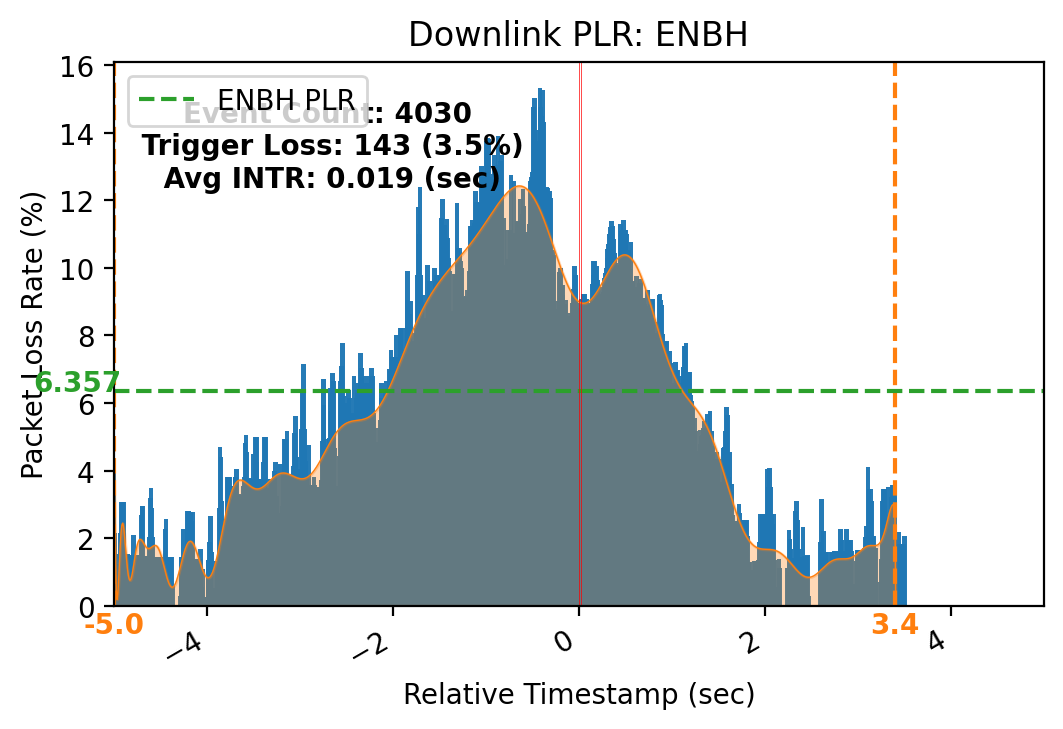

MCGH
Number of Event: 482
Number of Triggered: 69
Average Duration: 0.01852598755186722 seconds
[(-1.3, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.3, 5.0) 7.978


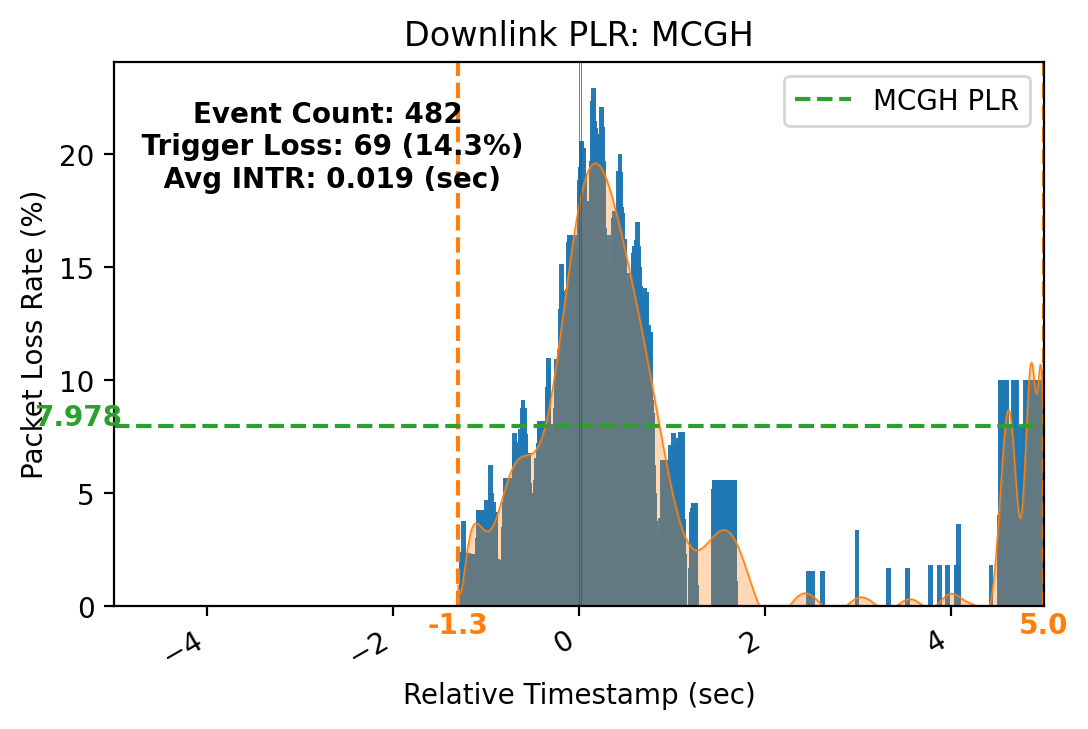

MNBH
Number of Event: 1494
Number of Triggered: 296
Average Duration: 0.02105363386880857 seconds
[(-4.7, 3.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.7, 3.8) 6.915


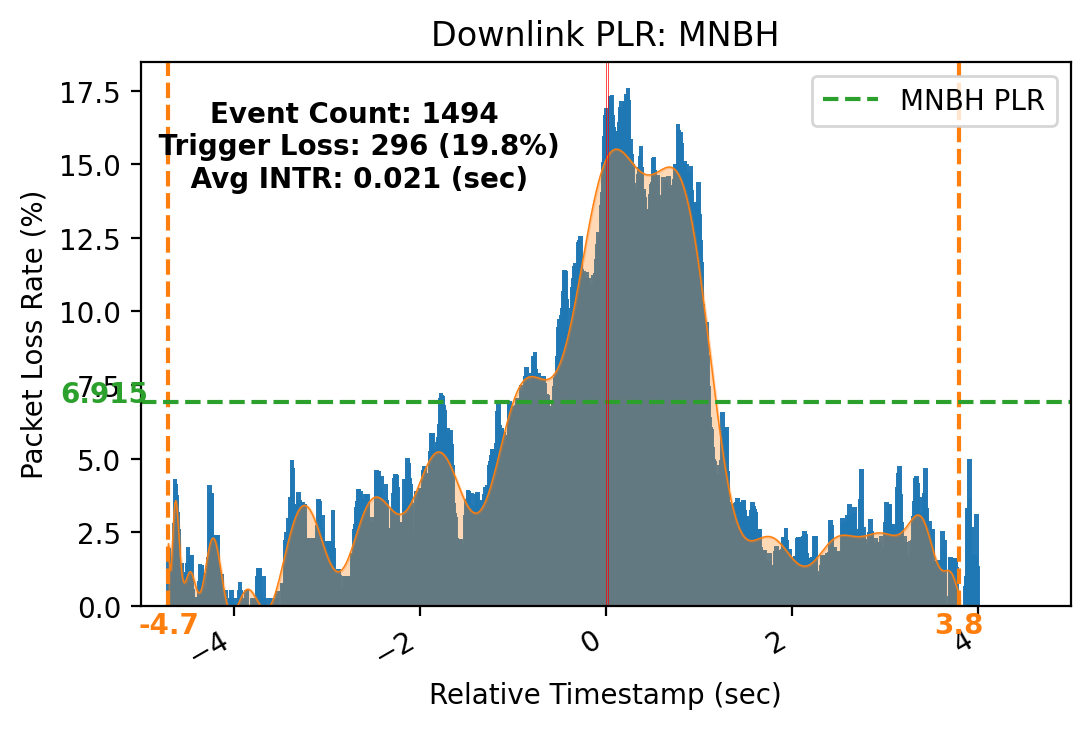

SCGA
Number of Event: 300
Number of Triggered: 23
Average Duration: 0.015681603333333335 seconds
[(-0.3, 5.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.3, 5.0) 5.051


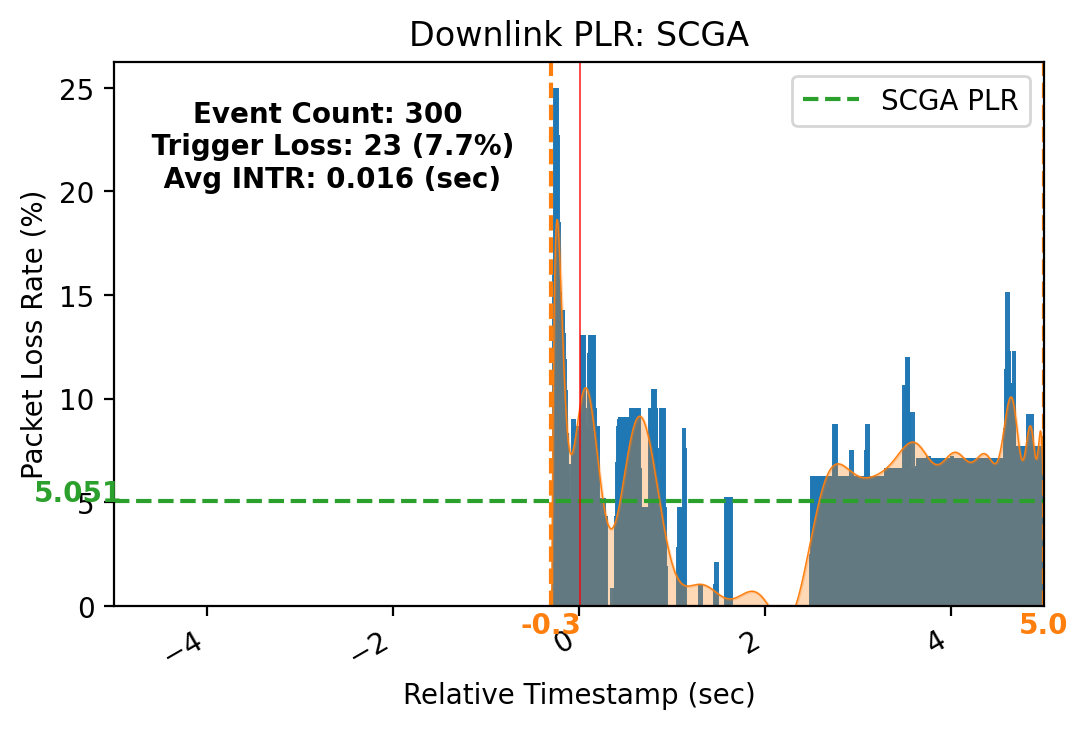

SCGM
Number of Event: 1696
Number of Triggered: 322
Average Duration: 0.0170713125 seconds
[(-4.2, 4.9)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.2, 4.9) 2.813


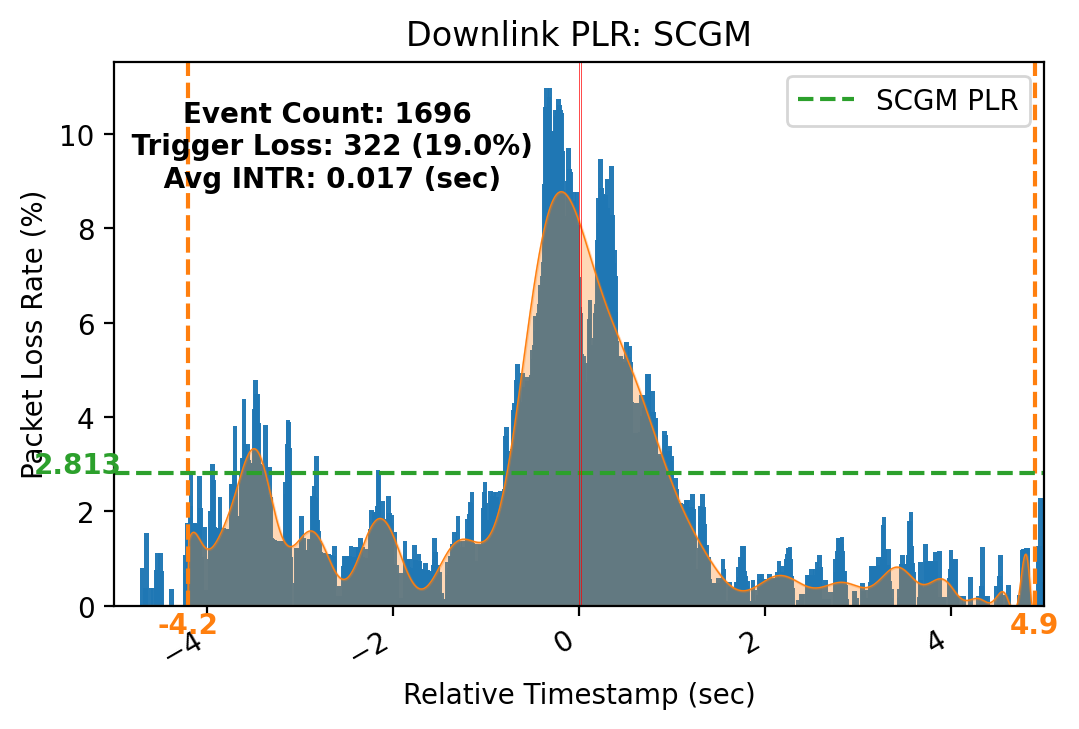

SCGR-I
Number of Event: 2
Number of Triggered: 1
Average Duration: 0.036322999999999994 seconds
[(-0.1, 1.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 1.2) 2.351


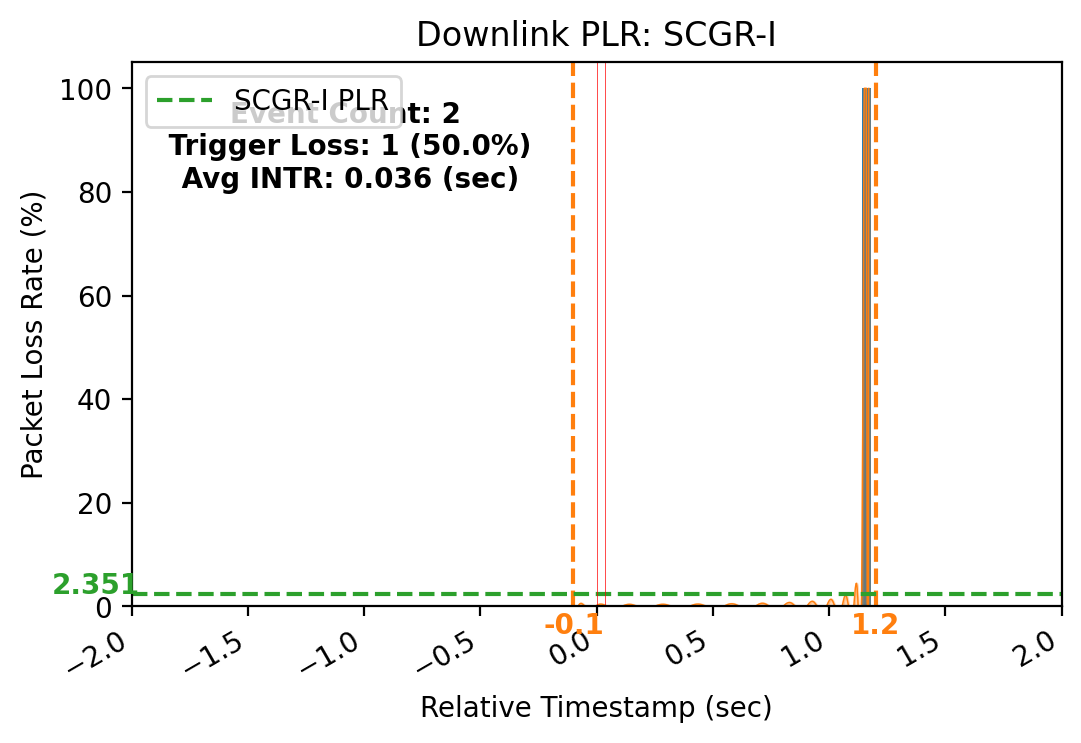

SCGR-II
Number of Event: 265
Number of Triggered: 16
Average Duration: 0.033766181132075475 seconds
[(-2.5, 1.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-2.5, 1.5) 17.634


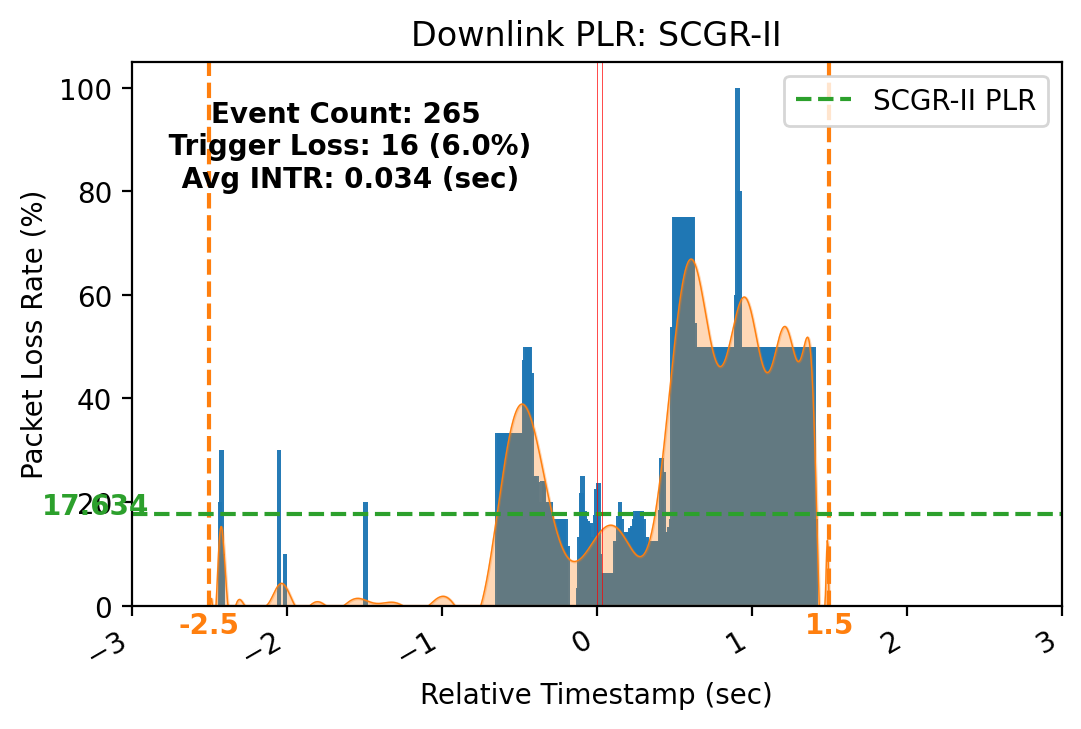

SCGC-I
Number of Event: 12
Number of Triggered: 10
Average Duration: 0.5283221666666666 seconds
[(-4.6, 2.7)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.6, 2.7) 3.144


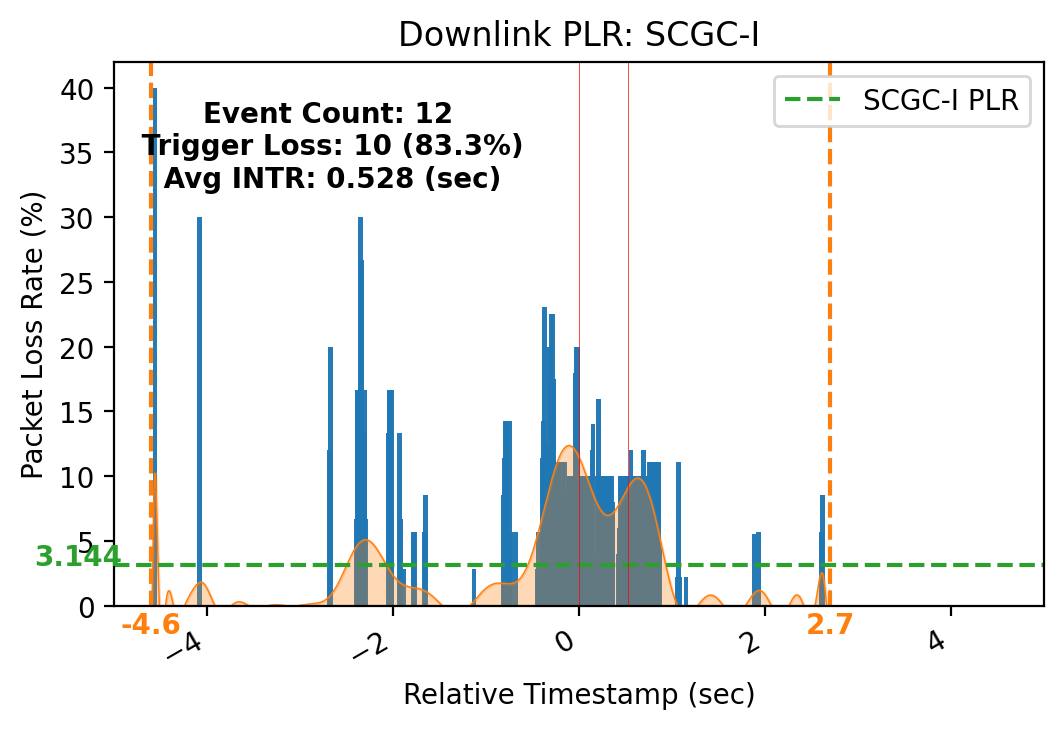

SCGC-II
Number of Event: 58
Number of Triggered: 14
Average Duration: 0.38874396551724144 seconds
[(-1.1, 4.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.1, 4.8) 8.881


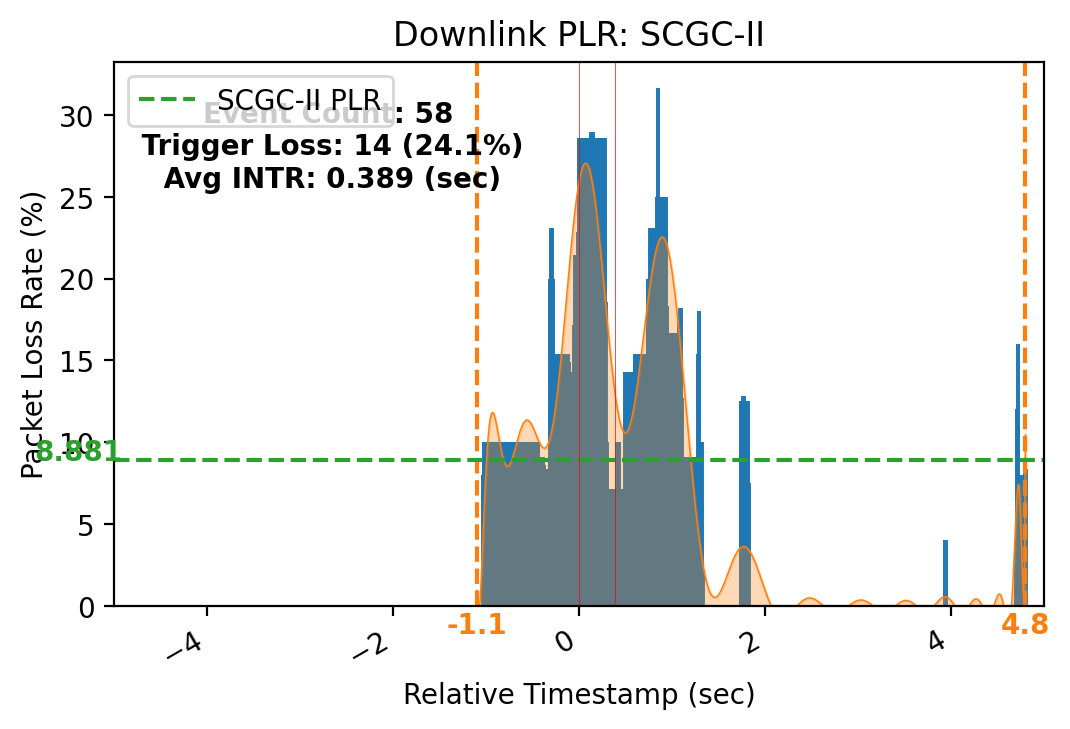

MCGF
Number of Event: 390
Number of Triggered: 342
Average Duration: 0.07972542307692308 seconds
[(-5.1, 1.7)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.1, 1.7) 31.109


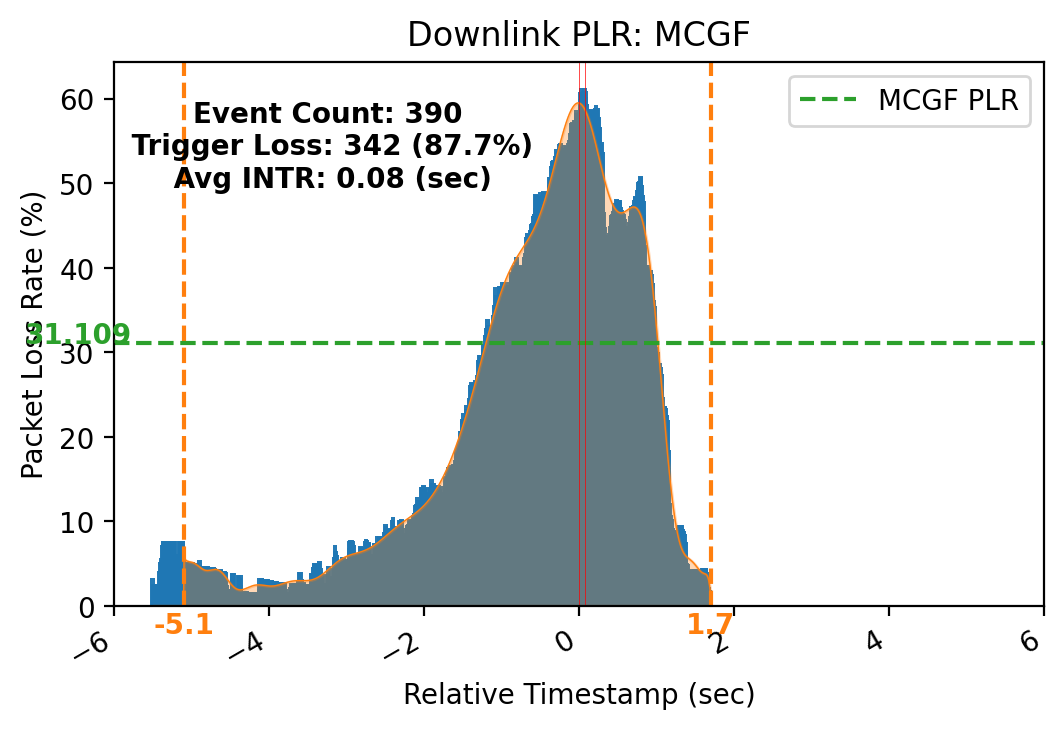

NASR
Number of Event: 11
Number of Triggered: 11
Average Duration: 0.44186245454545453 seconds
[(-4.0, 1.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.0, 1.5) 59.466


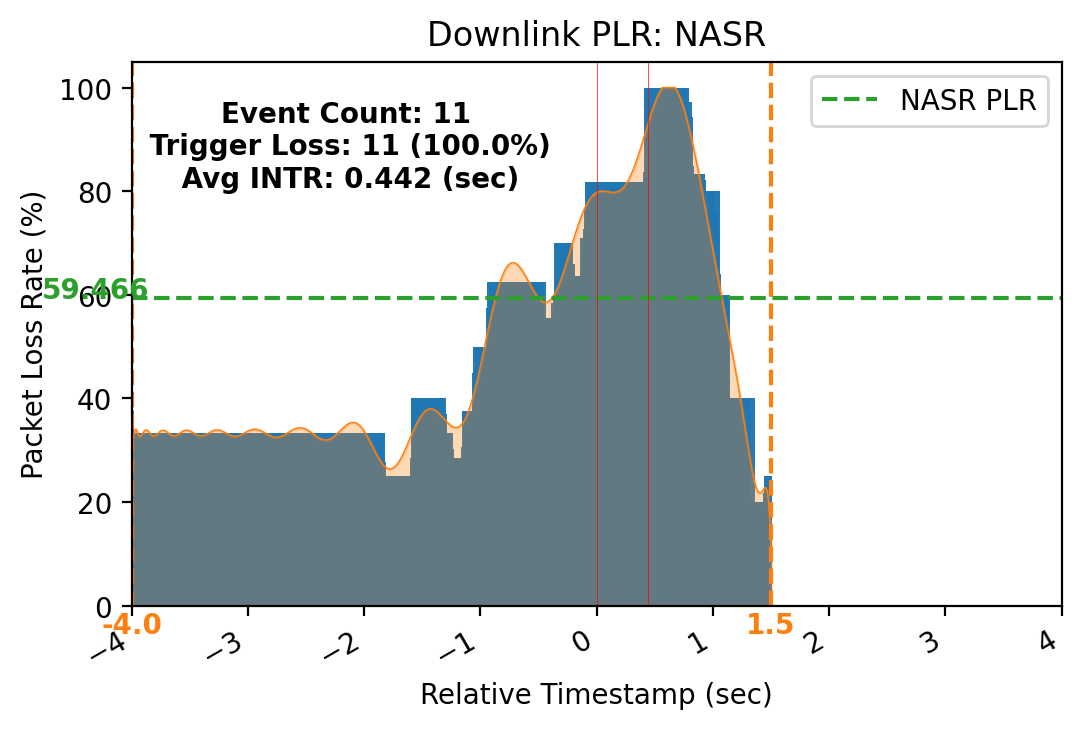

SCGF
Number of Event: 742
Number of Triggered: 25
Average Duration: 0.12380869002695419 seconds
[(-3.9, 1.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-3.9, 1.2) 12.106


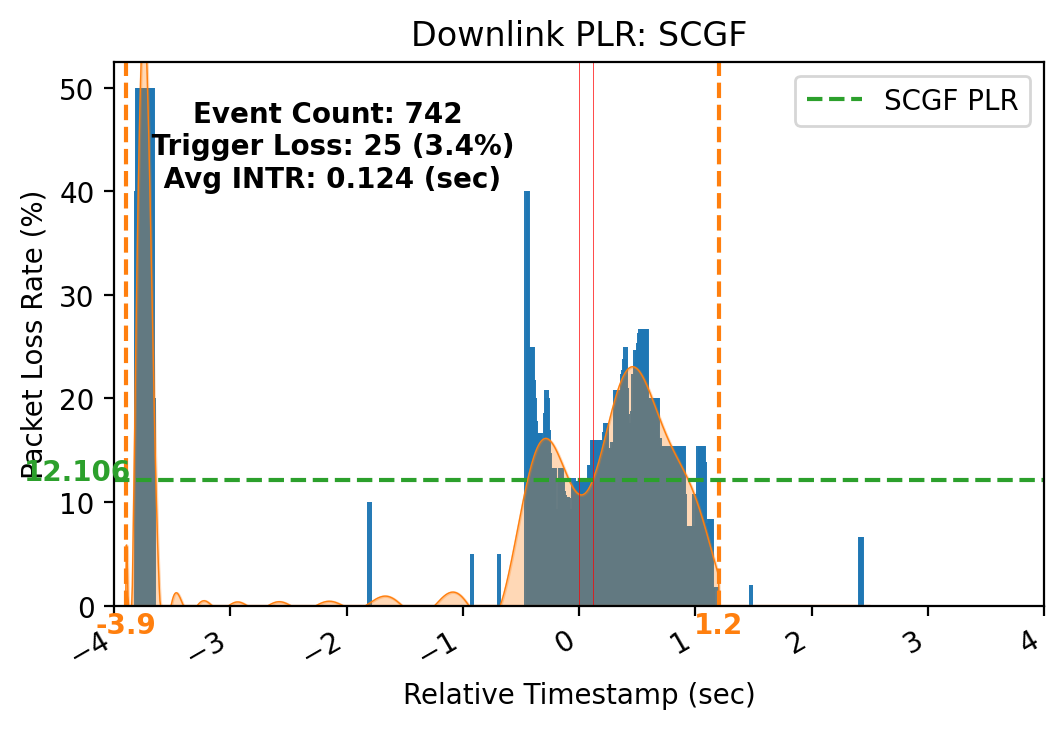

stable
Number of Event: 65325
Number of Triggered: 412
Average Duration: 1.0 seconds
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.5) 20.747


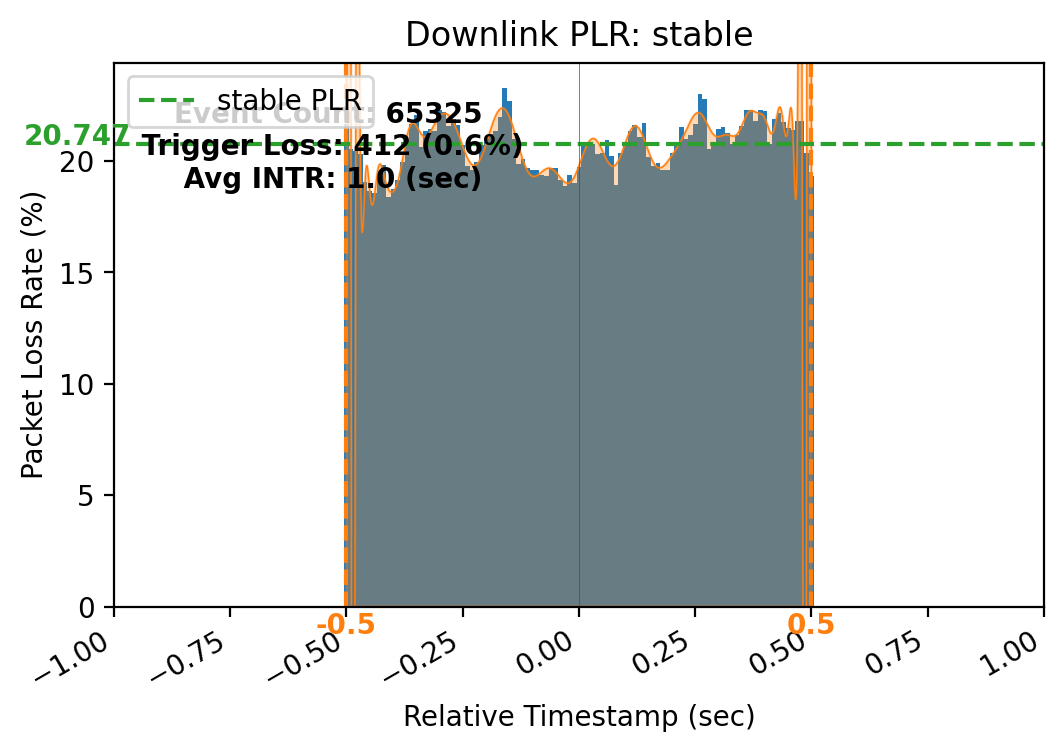

{'dl_lost': {'LTEH': (-4.4, 5.0),
             'ENBH': (-5.0, 3.4),
             'MCGH': (-1.3, 5.0),
             'MNBH': (-4.7, 3.8),
             'SCGA': (-0.3, 5.0),
             'SCGM': (-4.2, 4.9),
             'SCGR-I': (-0.1, 1.2),
             'SCGR-II': (-2.5, 1.5),
             'SCGC-I': (-4.6, 2.7),
             'SCGC-II': (-1.1, 4.8),
             'MCGF': (-5.1, 1.7),
             'NASR': (-4.0, 1.5),
             'SCGF': (-3.9, 1.2),
             'stable': (-0.5, 0.5)}}


In [52]:
# # de-comment while not running the first time
# D = HOType_D.copy()
# E = HOType_E.copy()
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# # *******************************************************************************************
D = HOType_D.copy()
E = HOType_E.copy()
scope = Initial_scope.copy()
# metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']
metrics=['dl_lost']

coef_tpl = pd.DataFrame(columns=['count', 'triggered', 'PLR/ELR', 'lower_bd', 'upper_bd', 'intr', *list(range(71))])
for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']:
    coef_tpl.loc[tag] = [0, 0, 0, -5, 5, 0, *np.zeros(71)]
for tag in ['MCGF', 'NASR', 'SCGF']:
    coef_tpl.loc[tag] = [0, 0, 0, -10, 10, 0, *np.zeros(71)]
coef_tpl.loc['stable'] = ['-', '-', 0, '-', '-', '-', *np.zeros(71)]
    
coef_df = {mets: coef_tpl.copy() for mets in metrics}

# coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

dist_df = {mets: {tag: pd.DataFrame(columns=['cat_id', 'tx_count', 'lost', 'PLR']) for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF', 'stable']} for mets in metrics}

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in metrics }

for tag in [*scope[list(scope.keys())[0]].keys(), 'stable']:
    if len(D[list(D.keys())[0]][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
    
    for mm in metrics:
        mode = mm[:2]
        mets = mm[-4:]
        
        if mets == 'lost':
            stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_PLR
        elif mets == 'excl':
            stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_ELR
            
        table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
        
        print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
        print('Number of Triggered:', sum(D[f'{mode}_{mets}'][tag]['triggered']))
        print('Average Duration:', intr, 'seconds')
        
        if tag == 'stable':
            min_scope = (-0.5, 0.5)
        else:
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
        
        if min_scope != 0:
            new_scope[f'{mode}_{mets}'][tag] = min_scope
        
        # def plot_polynomial(scope, mode, mets, ):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # # *********************************************************
        # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
        # new_scope[f'{mode}_{mets}'][tag] = min_scope
        # # *********************************************************
        
        if tag == 'stable':
            left = -0.5; right = 0.5
        else:
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
        bound = math.ceil(max(abs(right), abs(left)))
        left = -bound; right = bound
        ax.set_xlim(left, right)
        
        # width = 0.015 * (right - left)
        width = 0.005 * (right - left)
        if mets == 'lost':
            ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
        elif mets == 'excl':
            ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
            
        ax.set_ylim(0, max(1, ax.get_ylim()[1]))
        bottom, top = ax.get_ylim()

        if min_scope != 0:
            ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
            ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
            ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            
            bleft = min_scope[0]
            bright = min_scope[1]
            
            x = np.asarray(table['cat_id'], dtype=np.float64)
            if mets == 'lost':
                y = np.asarray(table['PLR'], dtype=np.float64)
            elif mets == 'excl':
                y = np.asarray(table['ELR'], dtype=np.float64)
                
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                z = np.polyfit(x, y, 70)
                p = np.poly1d(z)
            xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
            
            coef = p.coefficients
            
            ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
            ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
        
        if mets == 'lost':
            # ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
            # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable PLR:', stable_PLR)
                    print('Downlink PLR', min_scope, PLR)
                elif mode == 'ul':
                    print('Uplink Stable PLR:', stable_PLR)
                    print('Uplink PLR', min_scope, PLR)
                ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        elif mets == 'excl':
            # ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
            # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable ELR:', stable_ELR)
                    print('Downlink ELR', min_scope, ELR)
                elif mode == 'ul':
                    print('Uplink Stable ELR:', stable_ELR)
                    print('Uplink ELR', min_scope, ELR)
                ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                
        count = sum(D[f'{mode}_{mets}'][tag]['count'])
        triggered = sum(D[f'{mode}_{mets}'][tag]['triggered'])
        trigger_rate = sum(D[f'{mode}_{mets}'][tag]['triggered']) / (sum(D[f'{mode}_{mets}'][tag]['count']) + 1e-9) * 100
        intr = round(intr, 3)
        ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Trigger Loss: {triggered} ({round(trigger_rate, 1)}%)\n Avg INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
        
        # ******************************************************************************************************************
        if min_scope != 0:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, PLR, bleft, bright, intr, *list(coef)]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, ELR, bleft, bright, intr, *list(coef)]
            # display(table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)])
            dist_df[f'{mode}_{mets}'][tag] = table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)].reset_index(drop=True).copy()
        else:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            # display(table)
            dist_df[f'{mode}_{mets}'][tag] = table.copy()
        # ******************************************************************************************************************
        
        if mode == 'dl':
            if mets == 'lost':
                ax.set_title(f'Downlink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Downlink ELR: {tag}')
        elif mode == 'ul':
            if mets == 'lost':
                ax.set_title(f'Uplink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Uplink ELR: {tag}')
        
        if mets == 'lost':
            ax.set_ylabel('Packet Loss Rate (%)')
        elif mets == 'excl':
            ax.set_ylabel('Excessive Latency Rate (%)')
        ax.set_xlabel('Relative Timestamp (sec)')
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
# HOType_scope = new_scope.copy()

In [53]:
coef_dl_lost = coef_df['dl_lost'].copy()
dist_dl_lost = dist_df['dl_lost'].copy()

with open('./dist_dl_lost_BR.pkl', 'wb') as handle:
    pickle.dump(dist_dl_lost, handle, protocol=pickle.HIGHEST_PROTOCOL)
coef_dl_lost.to_pickle('./coef_dl_lost_BR.pkl')

In [54]:
coef_dl_lost

,count,triggered,PLR/ELR,lower_bd,upper_bd,intr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTEH,1271,0.055075,7.959,-4.4,5.0,0.019,3.433986e-39,-1.342104e-37,9.436451e-37,2.333108e-36,-2.611889e-35,3.776284e-35,-5.601681e-34,1.468309e-33,2.089343e-33,1.819744e-32,2.562359e-31,-8.123263e-31,4.840253e-30,-3.996905e-29,2.977072e-29,-6.484978e-28,-6.549596e-28,6.712702e-27,-2.841373e-26,5.984179e-25,-9.362504e-25,1.305796e-23,-2.665733e-23,1.337684e-23,-3.393638e-22,-7.116512e-21,1.205060e-20,-1.920569e-19,7.328363e-19,-8.071322e-19,1.312269e-17,8.606004e-17,-2.082175e-16,2.298020e-15,-1.517578e-14,-4.049487e-16,-1.770381e-13,-1.209243e-12,7.766298e-12,-1.760132e-11,2.390475e-10,4.073160e-10,-3.151394e-09,1.180620e-08,-1.829126e-07,-1.574786e-07,2.633264e-06,-4.980084e-06,1.015243e-04,1.118991e-04,-4.015390e-03,-1.350812e-04,6.747009e-02,-2.049510e-02,-6.898117e-01,3.210603e-01,4.684843e+00,-2.514315e+00,-2.164512e+01,1.178620e+01,6.747388e+01,-3.363955e+01,-1.366613e+02,5.469748e+01,1.651168e+02,-4.023076e+01,-95.096166,-0.263271,2.005998,7.892319,17.728562
ENBH,4030,0.035484,6.357,-5.0,3.4,0.019,-7.695298e-39,-6.123794e-38,1.465991e-37,4.467960e-37,-5.449871e-36,2.212132e-35,-4.475153e-35,-2.513231e-34,2.331437e-33,-1.530947e-32,4.556604e-32,-1.279701e-31,-7.746660e-31,4.946931e-30,-4.820665e-29,1.306603e-28,-8.018222e-28,-1.352051e-27,3.273368e-27,-1.459147e-25,3.448847e-25,-3.624384e-24,6.271712e-25,-2.318589e-23,-3.199445e-22,1.084943e-21,-1.007715e-20,2.960928e-20,-5.359884e-20,-3.902489e-20,5.538972e-18,-1.371829e-17,1.823659e-16,-1.661309e-18,1.173135e-15,1.435253e-14,-7.195871e-14,2.732784e-13,-1.787532e-12,-7.747780e-12,8.560957e-12,-3.425956e-10,7.281471e-10,2.123395e-09,-2.491325e-09,2.600768e-07,-1.145187e-07,-1.852101e-06,5.188232e-06,-1.575853e-04,-2.566554e-04,4.585752e-03,6.473065e-03,-6.206772e-02,-9.157286e-02,5.061776e-01,8.040252e-01,-2.655072e+00,-4.593159e+00,9.020891e+00,1.726717e+01,-1.926233e+01,-4.200797e+01,2.401196e+01,6.312648e+01,-1.489742e+01,-53.409694,3.023035,19.058154,-1.888647,8.998348
MCGH,482,0.143154,7.978,-1.3,5.0,0.019,1.644068e-38,-1.330267e-37,-3.121898e-37,1.102988e-36,1.169504e-35,4.834473e-35,7.206305e-35,-5.504326e-34,-5.658943e-33,-3.042126e-32,-1.061178e-31,-1.326490e-31,1.422995e-30,1.470311e-29,8.688812e-29,3.676823e-28,9.760915e-28,-6.937063e-28,-2.946792e-26,-2.318616e-25,-1.243808e-24,-4.875929e-24,-1.090129e-23,2.726120e-23,5.001666e-22,3.574392e-21,1.794646e-20,6.336025e-20,8.960149e-20,-8.221933e-19,-9.146188e-18,-5.602955e-17,-2.380222e-16,-5.682226e-16,1.298015e-15,2.493592e-14,1.698700e-13,7.382478e-13,1.587110e-12,-6.211283e-12,-8.869396e-11,-5.221857e-10,-1.674927e-09,9.670241e-10,4.994696e-08,3.269402e-07,9.438731e-07,-2.245729e-06,-3.868101e-05,-1.706179e-04,5.636819e-05,4.961986e-03,1.842112e-02,-3.780270e-02,-9.288271e-01,2.663205e+00,7.242556e+00,-3.634723e+01,1.217761e+01,1.325876e+02,-1.538392e+02,-1.885517e+02,3.637440e+02,7.987818e+01,-3.780226e+02,5.669108e+01,191.281445,-67.657939,-55.134928,21.677862,17.677052
MNBH,1494,0.198126,6.915,-4.7,3.8,0.021,-2.250294e-37,-8.826037e-37,1.130707e-35,1.739642e-35,-1.219474e-34,7.524323e-34,-2.263682e-33,-4.336023e-33,3.283995e-32,-3.941662e-31,1.064525e-30,-4.715365e-30,-2.723299e-30,8.003594e-29,-5.587066e-28,3.606467e-27,-8.972617e-27,4.025468e-26,1.032230e-25,-7.051281e-25,6.909667e-24,-3.234004e-23,1.017536e-22,-3.718038e-22,-1.285980e-21,6.488303e-21,-8.222866e-20,2.924498e-19,-1.159119e-18,2.694368e-18,1.800115e-17,-8.158666e-17,9.805031e-16,-2.528595e-15,9.587246e-15,2.364157e-16,-3.460826e-13,1.154408e-12,-1.056923e-11,1.080930e-11,4.220595e-11,-4.805427e-10,6.085238e-09,-6.373120e-09,1.724954e-08,2.584916e-07,-3.265864e-06,1.148193e-06,4.456912e-06,-1.583118e-04,1.751787e-03,3.430995e-03,-4.158211e-02,-4.169356e-02,5.054187e-01,3.300910e-01,-3.844212e+

# Evaluation Test

In [55]:
with open('./dist_dl_lost_BR.pkl', 'rb') as handle:
    dist_dl_lost = pickle.load(handle)
coef_dl_lost = pd.read_pickle('./coef_dl_lost_BR.pkl')

scope = {}
for tag, lower_bd, upper_bd in zip(coef_dl_lost.index[:-1], coef_dl_lost['lower_bd'].to_numpy()[:-1], coef_dl_lost['upper_bd'].to_numpy()[:-1]):
    # print(tag, lower_bd, upper_bd)
    scope[tag] = (lower_bd, upper_bd)

scope

{'LTEH': (-4.4, 5.0),
 'ENBH': (-5.0, 3.4),
 'MCGH': (-1.3, 5.0),
 'MNBH': (-4.7, 3.8),
 'SCGA': (-0.3, 5.0),
 'SCGM': (-4.2, 4.9),
 'SCGR-I': (-0.1, 1.2),
 'SCGR-II': (-2.5, 1.5),
 'SCGC-I': (-4.6, 2.7),
 'SCGC-II': (-1.1, 4.8),
 'MCGF': (-5.1, 1.7),
 'NASR': (-4.0, 1.5),
 'SCGF': (-3.9, 1.2)}

In [56]:
coef_dl_lost

,count,triggered,PLR/ELR,lower_bd,upper_bd,intr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTEH,1271,0.055075,7.959,-4.4,5.0,0.019,3.433986e-39,-1.342104e-37,9.436451e-37,2.333108e-36,-2.611889e-35,3.776284e-35,-5.601681e-34,1.468309e-33,2.089343e-33,1.819744e-32,2.562359e-31,-8.123263e-31,4.840253e-30,-3.996905e-29,2.977072e-29,-6.484978e-28,-6.549596e-28,6.712702e-27,-2.841373e-26,5.984179e-25,-9.362504e-25,1.305796e-23,-2.665733e-23,1.337684e-23,-3.393638e-22,-7.116512e-21,1.205060e-20,-1.920569e-19,7.328363e-19,-8.071322e-19,1.312269e-17,8.606004e-17,-2.082175e-16,2.298020e-15,-1.517578e-14,-4.049487e-16,-1.770381e-13,-1.209243e-12,7.766298e-12,-1.760132e-11,2.390475e-10,4.073160e-10,-3.151394e-09,1.180620e-08,-1.829126e-07,-1.574786e-07,2.633264e-06,-4.980084e-06,1.015243e-04,1.118991e-04,-4.015390e-03,-1.350812e-04,6.747009e-02,-2.049510e-02,-6.898117e-01,3.210603e-01,4.684843e+00,-2.514315e+00,-2.164512e+01,1.178620e+01,6.747388e+01,-3.363955e+01,-1.366613e+02,5.469748e+01,1.651168e+02,-4.023076e+01,-95.096166,-0.263271,2.005998,7.892319,17.728562
ENBH,4030,0.035484,6.357,-5.0,3.4,0.019,-7.695298e-39,-6.123794e-38,1.465991e-37,4.467960e-37,-5.449871e-36,2.212132e-35,-4.475153e-35,-2.513231e-34,2.331437e-33,-1.530947e-32,4.556604e-32,-1.279701e-31,-7.746660e-31,4.946931e-30,-4.820665e-29,1.306603e-28,-8.018222e-28,-1.352051e-27,3.273368e-27,-1.459147e-25,3.448847e-25,-3.624384e-24,6.271712e-25,-2.318589e-23,-3.199445e-22,1.084943e-21,-1.007715e-20,2.960928e-20,-5.359884e-20,-3.902489e-20,5.538972e-18,-1.371829e-17,1.823659e-16,-1.661309e-18,1.173135e-15,1.435253e-14,-7.195871e-14,2.732784e-13,-1.787532e-12,-7.747780e-12,8.560957e-12,-3.425956e-10,7.281471e-10,2.123395e-09,-2.491325e-09,2.600768e-07,-1.145187e-07,-1.852101e-06,5.188232e-06,-1.575853e-04,-2.566554e-04,4.585752e-03,6.473065e-03,-6.206772e-02,-9.157286e-02,5.061776e-01,8.040252e-01,-2.655072e+00,-4.593159e+00,9.020891e+00,1.726717e+01,-1.926233e+01,-4.200797e+01,2.401196e+01,6.312648e+01,-1.489742e+01,-53.409694,3.023035,19.058154,-1.888647,8.998348
MCGH,482,0.143154,7.978,-1.3,5.0,0.019,1.644068e-38,-1.330267e-37,-3.121898e-37,1.102988e-36,1.169504e-35,4.834473e-35,7.206305e-35,-5.504326e-34,-5.658943e-33,-3.042126e-32,-1.061178e-31,-1.326490e-31,1.422995e-30,1.470311e-29,8.688812e-29,3.676823e-28,9.760915e-28,-6.937063e-28,-2.946792e-26,-2.318616e-25,-1.243808e-24,-4.875929e-24,-1.090129e-23,2.726120e-23,5.001666e-22,3.574392e-21,1.794646e-20,6.336025e-20,8.960149e-20,-8.221933e-19,-9.146188e-18,-5.602955e-17,-2.380222e-16,-5.682226e-16,1.298015e-15,2.493592e-14,1.698700e-13,7.382478e-13,1.587110e-12,-6.211283e-12,-8.869396e-11,-5.221857e-10,-1.674927e-09,9.670241e-10,4.994696e-08,3.269402e-07,9.438731e-07,-2.245729e-06,-3.868101e-05,-1.706179e-04,5.636819e-05,4.961986e-03,1.842112e-02,-3.780270e-02,-9.288271e-01,2.663205e+00,7.242556e+00,-3.634723e+01,1.217761e+01,1.325876e+02,-1.538392e+02,-1.885517e+02,3.637440e+02,7.987818e+01,-3.780226e+02,5.669108e+01,191.281445,-67.657939,-55.134928,21.677862,17.677052
MNBH,1494,0.198126,6.915,-4.7,3.8,0.021,-2.250294e-37,-8.826037e-37,1.130707e-35,1.739642e-35,-1.219474e-34,7.524323e-34,-2.263682e-33,-4.336023e-33,3.283995e-32,-3.941662e-31,1.064525e-30,-4.715365e-30,-2.723299e-30,8.003594e-29,-5.587066e-28,3.606467e-27,-8.972617e-27,4.025468e-26,1.032230e-25,-7.051281e-25,6.909667e-24,-3.234004e-23,1.017536e-22,-3.718038e-22,-1.285980e-21,6.488303e-21,-8.222866e-20,2.924498e-19,-1.159119e-18,2.694368e-18,1.800115e-17,-8.158666e-17,9.805031e-16,-2.528595e-15,9.587246e-15,2.364157e-16,-3.460826e-13,1.154408e-12,-1.056923e-11,1.080930e-11,4.220595e-11,-4.805427e-10,6.085238e-09,-6.373120e-09,1.724954e-08,2.584916e-07,-3.265864e-06,1.148193e-06,4.456912e-06,-1.583118e-04,1.751787e-03,3.430995e-03,-4.158211e-02,-4.169356e-02,5.054187e-01,3.300910e-01,-3.844212e+

In [57]:
dist_dl_lost

{'LTEH':      cat_id  tx_count  lost       PLR
 0     -4.40      41.0     0       0.0
 1     -4.39      85.0     0       0.0
 2     -4.38      85.0     0       0.0
 3     -4.37      85.0     5  5.882353
 4     -4.36      85.0     5  5.882353
 ..      ...       ...   ...       ...
 936    4.96     104.0     4  3.846154
 937    4.97     100.0     0       0.0
 938    4.98     100.0     0       0.0
 939    4.99     100.0     3       3.0
 940    5.00      49.0     2  4.081633
 
 [941 rows x 4 columns],
 'ENBH':      cat_id  tx_count  lost       PLR
 0     -5.00     161.0     7  4.347826
 1     -4.99     325.0     7  2.153846
 2     -4.98     325.0     5  1.538462
 3     -4.97     325.0     1  0.307692
 4     -4.96     325.0     0       0.0
 ..      ...       ...   ...       ...
 836    3.36     280.0     9  3.214286
 837    3.37     280.0    10  3.571429
 838    3.38     280.0    10  3.571429
 839    3.39     280.0    10  3.571429
 840    3.40     280.0     9  3.214286
 
 [841 rows x 4 colu

## Predict BR

In [58]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['BR']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

sampled_filepaths = filepaths[-9:]

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'skip': False, 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'ue': 'Phone', 'sync': None, 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園',

In [59]:
LOSS_GT = []
LOSS_EV = []
LOSS_STD = []

N = 10
for j, s in enumerate(sampled_filepaths):
    print(f'{j+1}/{len(sampled_filepaths)}', s[0])
    ho_df = pd.read_csv(s[0], parse_dates=['start', 'end'])
    dl_df = pd.read_csv(s[1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
    loss_rate_list = []
    for iter_round in tqdm(range(N), ncols=1000):
        df_now = None
        df_remaining = dl_df.copy()
        df_ho = ho_df.copy()
        for i, row in df_ho.iterrows():
            prior_row = df_ho.iloc[i-1] if i != 0 else None
            post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
            
            # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
            if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                print(i, row['start'], row['end'], row['type'], row['cause'])
                print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = df_ho.iloc[i-2] if i > 1 else None
            
            # Basic information
            tag = row['type']  # specific column name
            start, end = row['start'], row['end']  # handover start/end time
            intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
            
            triggered_p = coef_dl_lost.loc[tag, 'triggered']
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                if pd.notna(prior_row['end']):
                    left = prior_row['end'] + (start - prior_row['end']) / 2
                else:
                    left = prior_row['start'] + (start - prior_row['start']) / 2
            else:
                left = pd.Timestamp.min
            if post_row is not None:
                if pd.notna(end):
                    right = end + (post_row['start'] - end) / 2
                else:
                    right = start + (post_row['start'] - start) / 2
            else:
                right = pd.Timestamp.max

            # Centered at start timestamp of each handover event
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
            
            df_now = df_remaining[df_remaining['Timestamp'] < intv.upper]
            df_remaining = df_remaining[df_remaining['Timestamp'] >= intv.upper]
            
            plr_mapping = dist_dl_lost[tag].copy()
            # print(plr_mapping)
            
            # print(df_now)
            # print(df_remaining)
            
            df_now[f'rel_time'] = (df_now['Timestamp'] - start).dt.total_seconds()
            df_now[f'cat_id'] = ((df_now[f'rel_time'] + 0.005) // 0.01) * 0.01
            # print(df_now)
            
            # display(plr_mapping)
            if plr_mapping.empty:
                tmp = df_now.copy().rename(columns={'lost': 'lost_x'})
            else:
                tmp = pd.merge(df_now, plr_mapping, on='cat_id', how='left')
                tmp['PLR'] = tmp['PLR'].fillna(0)
                
                if not generate_random_boolean(triggered_p):
                    tmp['PLR'] = 0
            # display(tmp)
            
            # print(tmp)
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)

        answer = pd.concat([answer, df_remaining], axis=0)
        
        # Consider stable duration
        df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        df['Timestamp_sec'] = df['Timestamp'].dt.floor('S')
        df['rel_time'] = (df['Timestamp'] - df['Timestamp_sec']).dt.total_seconds() - 0.5
        df['cat_id'] = ((df['rel_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = dist_dl_lost['stable'].copy()
        df = pd.merge(df, plr_mapping, on='cat_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = df[~df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = coef_dl_lost.loc['stable', 'triggered']
        random_bool_array = [generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        df = pd.merge(df, trig_p_mapping, on='Timestamp_sec', how='left')
        df['PLR'] = df['PLR_trig'] * df['trigger']

        del df['Timestamp_sec'], df['PLR_trig'], df['trigger']

        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(generate_random_boolean)

        # print(len(dl_df))
        # print(len(answer))

        # print(dl_df['lost'].mean() * 100)
        # print(answer['Y'].mean() * 100)
        # print(answer['PLR'].mean() * 100)

        loss_rate_list.append(answer['Y'].mean() * 100)

    gt_value = dl_df['lost'].mean() * 100
    mean_value = np.mean(loss_rate_list)
    std_deviation = np.std(loss_rate_list)

    print()
    print("Mean:", mean_value)
    print("Standard Deviation:", std_deviation)
    print("Ground Truth:", gt_value)
    
    LOSS_GT.append(gt_value)
    LOSS_EV.append(mean_value)
    LOSS_STD.append(std_deviation)
    
    print('****************************************************************')
    print()

1/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping event occurs!!
113 2023-11-09 13:52:54.142049 2023-11-09 13:52:54.915901 SCGC-II nan
114 2023-11-09 13:52:54.737656 2023-11-09 13:52:54.768234 LTEH nan
Overlapping even

  0%|                                                                                                         …


Mean: 1.166139448137611
Standard Deviation: 0.05289486122183842
Ground Truth: 1.6851681748001641
****************************************************************

3/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping event occurs!!
125 2023-11-09 13:52:54.900047 2023-11-09 13:52:55.508435 SCGC-II nan
126 2023-11-09 13:52:55.317134 2023-11-09 13:52:55.347119 LTEH nan
Overlapping even

  0%|                                                                                                         …

Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping event occurs!!
170 2023-11-09 14:04:30.863867 2023-11-09 14:04:31.334496 SCGC-II nan
171 2023-11-09 14:04:31.146542 2023-11-09 14:04:31.173226 LTEH nan
Overlapping even

  0%|                                                                                                         …

Overlapping event occurs!!
5 2023-11-09 13:07:16.730573 2023-11-09 13:07:17.809186 SCGC-II nan
6 2023-11-09 13:07:17.607144 2023-11-09 13:07:17.627098 LTEH nan
Overlapping event occurs!!
28 2023-11-09 13:07:32.750471 2023-11-09 13:07:33.830786 SCGC-II nan
29 2023-11-09 13:07:33.634211 2023-11-09 13:07:33.654191 LTEH nan
Overlapping event occurs!!
51 2023-11-09 13:40:54.953052 2023-11-09 13:40:56.201954 SCGC-II nan
52 2023-11-09 13:40:56.042929 2023-11-09 13:40:56.063883 LTEH nan
Overlapping event occurs!!
68 2023-11-09 13:41:02.469236 2023-11-09 13:41:03.450744 SCGC-II nan
69 2023-11-09 13:41:03.271817 2023-11-09 13:41:03.301786 LTEH nan
Overlapping event occurs!!
73 2023-11-09 13:41:04.849585 2023-11-09 13:41:05.556824 SCGC-II nan
74 2023-11-09 13:41:05.386903 2023-11-09 13:41:05.407804 LTEH nan
Overlapping event occurs!!
75 2023-11-09 13:41:06.008765 2023-11-09 13:41:06.637842 SCGC-II nan
76 2023-11-09 13:41:06.464051 2023-11-09 13:41:06.483864 LTEH nan
Overlapping event occurs!!
164

  0%|                                                                                                         …

Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping event occurs!!
105 2023-11-09 13:52:53.629153 2023-11-09 13:52:54.382071 SCGC-II nan
106 2023-11-09 13:52:54.209654 2023-11-09 13:52:54.241942 LTEH nan
Overlapping even

  0%|                                                                                                         …

Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping event occurs!!
111 2023-11-09 13:52:53.319267 2023-11-09 13:52:54.448320 SCGC-II nan
112 2023-11-09 13:52:54.269673 2023-11-09 13:52:54.295351 LTEH nan
Overlapping even

  0%|                                                                                                         …


Mean: 0.8199758210647108
Standard Deviation: 0.08978214498185329
Ground Truth: 0.856663027727599
****************************************************************

9/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.427022687609075
Standard Deviation: 0.04505733137661586
Ground Truth: 0.24167539267015709
****************************************************************



In [60]:
# LOSS_GT = LOSS_GT_BR.copy()
# LOSS_EV = LOSS_EV_BR.copy()
# LOSS_STD = LOSS_STD_BR.copy()

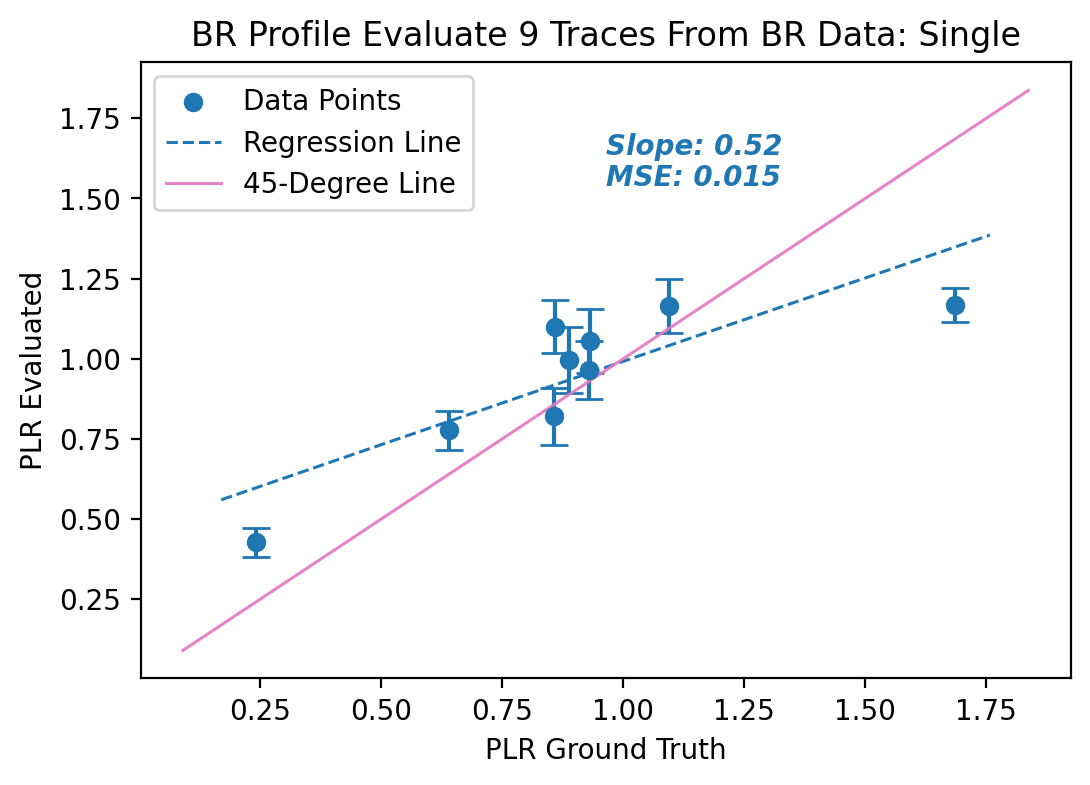

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Sample data
x = LOSS_GT.copy()
y = LOSS_EV.copy()

# Standard deviations for error bars
y_error = LOSS_STD.copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot with error bars and horizontal caps
ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

# Regression line
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)
ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

# Annotate the slope of the regression line
slope_annotation = f'Slope: {coefficients[0]:.2f}'
ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# Annotate MSE From the regression line
y_pred = regression_line(x)
mse = mean_squared_error(y, y_pred)
slope_annotation = f'MSE: {mse:.3f}'
ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# 45-Degree Line
ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

# Set labels and title
ax.set_xlabel('PLR Ground Truth')
ax.set_ylabel('PLR Evaluated')
ax.set_title('BR Profile Evaluate 9 Traces From BR Data: Single')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [62]:
LOSS_GT_BR = LOSS_GT.copy()
LOSS_EV_BR = LOSS_EV.copy()
LOSS_STD_BR = LOSS_STD.copy()

## Predict A

In [63]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['A']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

sampled_filepaths = filepaths[-9:]

2023-10-26 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '13:30', '直達車'], [2, '機場第二航廈', '台北車站', '14:25', '直達車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心', '泰山', '泰山貴和', '體育大學', '長庚醫院', '林口', '山鼻', '坑口', '機場第一航廈', '機場第二航廈'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-11-01 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '14:52', '普通車'], [2, '機場第二航廈', '台北車站', '16:04', '普通車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心',

In [64]:
LOSS_GT = []
LOSS_EV = []
LOSS_STD = []

N = 10
for j, s in enumerate(sampled_filepaths):
    print(f'{j+1}/{len(sampled_filepaths)}', s[0])
    ho_df = pd.read_csv(s[0], parse_dates=['start', 'end'])
    dl_df = pd.read_csv(s[1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
    loss_rate_list = []
    for iter_round in tqdm(range(N), ncols=1000):
        df_now = None
        df_remaining = dl_df.copy()
        df_ho = ho_df.copy()
        for i, row in df_ho.iterrows():
            prior_row = df_ho.iloc[i-1] if i != 0 else None
            post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
            
            # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
            if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                print(i, row['start'], row['end'], row['type'], row['cause'])
                print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = df_ho.iloc[i-2] if i > 1 else None
            
            # Basic information
            tag = row['type']  # specific column name
            start, end = row['start'], row['end']  # handover start/end time
            intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
            
            triggered_p = coef_dl_lost.loc[tag, 'triggered']
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                if pd.notna(prior_row['end']):
                    left = prior_row['end'] + (start - prior_row['end']) / 2
                else:
                    left = prior_row['start'] + (start - prior_row['start']) / 2
            else:
                left = pd.Timestamp.min
            if post_row is not None:
                if pd.notna(end):
                    right = end + (post_row['start'] - end) / 2
                else:
                    right = start + (post_row['start'] - start) / 2
            else:
                right = pd.Timestamp.max

            # Centered at start timestamp of each handover event
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
            
            df_now = df_remaining[df_remaining['Timestamp'] < intv.upper]
            df_remaining = df_remaining[df_remaining['Timestamp'] >= intv.upper]
            
            plr_mapping = dist_dl_lost[tag].copy()
            # print(plr_mapping)
            
            # print(df_now)
            # print(df_remaining)
            
            df_now[f'rel_time'] = (df_now['Timestamp'] - start).dt.total_seconds()
            df_now[f'cat_id'] = ((df_now[f'rel_time'] + 0.005) // 0.01) * 0.01
            # print(df_now)
            
            # display(plr_mapping)
            if plr_mapping.empty:
                tmp = df_now.copy().rename(columns={'lost': 'lost_x'})
            else:
                tmp = pd.merge(df_now, plr_mapping, on='cat_id', how='left')
                tmp['PLR'] = tmp['PLR'].fillna(0)
                
                if not generate_random_boolean(triggered_p):
                    tmp['PLR'] = 0
            # display(tmp)
            
            # print(tmp)
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)

        answer = pd.concat([answer, df_remaining], axis=0)
        
        # Consider stable duration
        df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        df['Timestamp_sec'] = df['Timestamp'].dt.floor('S')
        df['rel_time'] = (df['Timestamp'] - df['Timestamp_sec']).dt.total_seconds() - 0.5
        df['cat_id'] = ((df['rel_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = dist_dl_lost['stable'].copy()
        df = pd.merge(df, plr_mapping, on='cat_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = df[~df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = coef_dl_lost.loc['stable', 'triggered']
        random_bool_array = [generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        df = pd.merge(df, trig_p_mapping, on='Timestamp_sec', how='left')
        df['PLR'] = df['PLR_trig'] * df['trigger']

        del df['Timestamp_sec'], df['PLR_trig'], df['trigger']

        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(generate_random_boolean)

        # print(len(dl_df))
        # print(len(answer))

        # print(dl_df['lost'].mean() * 100)
        # print(answer['Y'].mean() * 100)
        # print(answer['PLR'].mean() * 100)

        loss_rate_list.append(answer['Y'].mean() * 100)

    gt_value = dl_df['lost'].mean() * 100
    mean_value = np.mean(loss_rate_list)
    std_deviation = np.std(loss_rate_list)

    print()
    print("Mean:", mean_value)
    print("Standard Deviation:", std_deviation)
    print("Ground Truth:", gt_value)
    
    LOSS_GT.append(gt_value)
    LOSS_EV.append(mean_value)
    LOSS_STD.append(std_deviation)
    
    print('****************************************************************')
    print()

1/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
278 2023-11-02 18:30:55.337862 2023-11-02 18:30:55.740098 SCGF t310-Expiry (0)
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
Overlapping event occurs!!
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
280 2023-11-02 18:30:55.716514 2023-11-02 18:30:56.348931 SCGC-II nan
Overlapping event occurs!!
278 2023-11-02 18:30:55.337862 2023-11-02 18:30:55.740098 SCGF t310-Expiry (0)
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
Overlapping event occurs!!
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
280 2023-11-02 18:30:55.716514 2023-11-02 18:30:56.348931 SCGC-II nan
Overlapping event occurs!!
278 2023-11-02 18:30:55.337862 2023-11-02 18:30:55.740098 SCGF t310-Expiry (0)
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
Overlapping event occurs!!
279 2023-11-02 18:30:55.646618 2023-11-02 18:30:55.740098 SCGF nan
280 2023-11-02 18:30:55.716514 2023-11-02 18:30:56.348931 S

  0%|                                                                                                         …


Mean: 1.71303177318489
Standard Deviation: 0.12621215511441114
Ground Truth: 3.518375857592259
****************************************************************

3/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv


  0%|                                                                                                         …

Overlapping event occurs!!
208 2023-11-02 18:24:07.147994 2023-11-02 18:24:07.690488 SCGC-II nan
209 2023-11-02 18:24:07.409293 2023-11-02 18:24:07.434108 LTEH nan
Overlapping event occurs!!
255 2023-11-02 18:29:04.503816 2023-11-02 18:29:04.931515 MCGH nan
256 2023-11-02 18:29:04.750702 2023-11-02 18:29:04.849058 MCGF handoverFailure (1)
Overlapping event occurs!!
208 2023-11-02 18:24:07.147994 2023-11-02 18:24:07.690488 SCGC-II nan
209 2023-11-02 18:24:07.409293 2023-11-02 18:24:07.434108 LTEH nan
Overlapping event occurs!!
255 2023-11-02 18:29:04.503816 2023-11-02 18:29:04.931515 MCGH nan
256 2023-11-02 18:29:04.750702 2023-11-02 18:29:04.849058 MCGF handoverFailure (1)
Overlapping event occurs!!
208 2023-11-02 18:24:07.147994 2023-11-02 18:24:07.690488 SCGC-II nan
209 2023-11-02 18:24:07.409293 2023-11-02 18:24:07.434108 LTEH nan
Overlapping event occurs!!
255 2023-11-02 18:29:04.503816 2023-11-02 18:29:04.931515 MCGH nan
256 2023-11-02 18:29:04.750702 2023-11-02 18:29:04.849058 MC

  0%|                                                                                                         …

Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 2023-11-02 18:12:32.635233 MCGH nan
110 2023-11-02 18:12:32.460537 2023-11-02 18:12:32.548924 MCGF handoverFailure (1)
Overlapping event occurs!!
158 2023-11-02 18:18:45.069357 2023-11-02 18:18:45.966701 MCGH nan
159 2023-11-02 18:18:45.827525 2023-11-02 18:18:45.914665 MCGF handoverFailure (1)
Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 2023-11-02 18:12:32.635233 MCGH nan
110 2023-11-02 18:12:32.460537 2023-11-02 18:12:32.548924 MCGF handoverFailure (1)
Overlapping event occurs!!
158 2023-11-02 18:18:45.069357 2023-11-02 18:18:45.966701 MCGH nan
159 2023-11-02 18:18:45.827525 2023-11-02 18:18:45.914665 MCGF handoverFailure (1)
Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 2023-11-02 18:12:32.635233 MCGH nan
110 2023-11-02 18:12:32.460537 2023-11-02 18:12:32.548924 MCGF handoverFailure (1)
Overlapping event occurs!!
158 2023-11-02 18:18:45.069357 2023-11-02 18:18:45.966701 MCGH nan
159 2023-11-02 18:18:

  0%|                                                                                                         …

Overlapping event occurs!!
47 2023-11-02 18:04:19.323781 2023-11-02 18:04:19.768391 MCGH nan
48 2023-11-02 18:04:19.612787 2023-11-02 18:04:19.682868 MCGF handoverFailure (1)
Overlapping event occurs!!
77 2023-11-02 18:08:40.860443 2023-11-02 18:08:42.283077 SCGC-II nan
78 2023-11-02 18:08:41.275805 2023-11-02 18:08:41.295459 ENBH nan
Overlapping event occurs!!
84 2023-11-02 18:08:47.376502 2023-11-02 18:08:48.390529 SCGC-II nan
85 2023-11-02 18:08:48.230666 2023-11-02 18:08:48.249421 LTEH nan
Overlapping event occurs!!
225 2023-11-02 18:28:23.846389 2023-11-02 18:28:24.271650 MCGH nan
226 2023-11-02 18:28:24.137935 2023-11-02 18:28:24.210089 MCGF handoverFailure (1)
Overlapping event occurs!!
228 2023-11-02 18:28:27.979511 2023-11-02 18:28:28.742679 SCGC-II nan
229 2023-11-02 18:28:28.290810 2023-11-02 18:28:28.308167 ENBH nan
Overlapping event occurs!!
234 2023-11-02 18:28:44.409095 2023-11-02 18:28:45.042558 SCGC-I nan
235 2023-11-02 18:28:44.686860 2023-11-02 18:28:44.704247 ENBH n

  0%|                                                                                                         …


Mean: 1.468577494166813
Standard Deviation: 0.053721433786209714
Ground Truth: 2.8880151823690534
****************************************************************

7/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 1.9560268619342112
Standard Deviation: 0.06697476247983374
Ground Truth: 2.531956694946149
****************************************************************

8/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 0.8930510964074913
Standard Deviation: 0.09350581704928076
Ground Truth: 1.4566809973353698
****************************************************************

9/9 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv


  0%|                                                                                                         …


Mean: 1.1522090606130597
Standard Deviation: 0.1175687433441721
Ground Truth: 3.2168310951265386
****************************************************************



In [65]:
# LOSS_GT = LOSS_GT_A.copy()
# LOSS_EV = LOSS_EV_A.copy()
# LOSS_STD = LOSS_STD_A.copy()

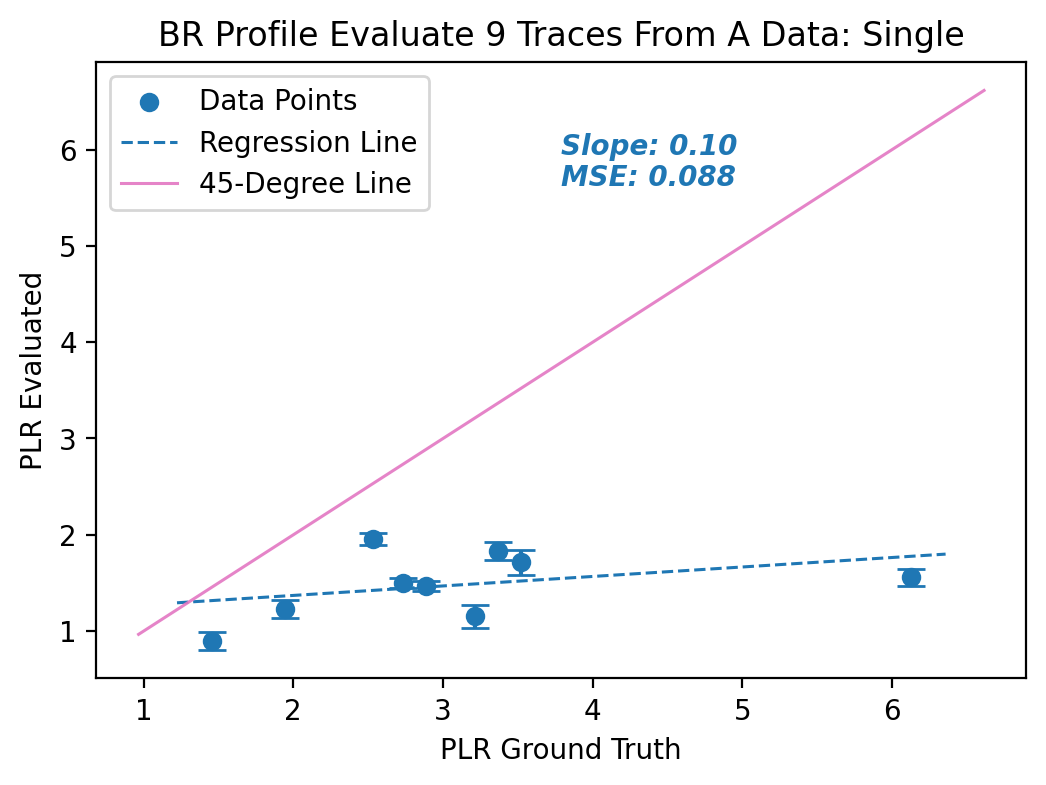

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Sample data
x = LOSS_GT.copy()
y = LOSS_EV.copy()

# Standard deviations for error bars
y_error = LOSS_STD.copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot with error bars and horizontal caps
ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

# Regression line
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)
ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

# Annotate the slope of the regression line
slope_annotation = f'Slope: {coefficients[0]:.2f}'
ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# Annotate MSE From the regression line
y_pred = regression_line(x)
mse = mean_squared_error(y, y_pred)
slope_annotation = f'MSE: {mse:.3f}'
ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# 45-Degree Line
ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

# Set labels and title
ax.set_xlabel('PLR Ground Truth')
ax.set_ylabel('PLR Evaluated')
ax.set_title('BR Profile Evaluate 9 Traces From A Data: Single')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [67]:
LOSS_GT_A = LOSS_GT.copy()
LOSS_EV_A = LOSS_EV.copy()
LOSS_STD_A = LOSS_STD.copy()